# 4.0 Home Run Rates
Attempting to predict home run rates based on batted ball type and direction

## Libraries

In [1]:
import os
import pandas as pd
import numpy as np

from pandas_gbq import read_gbq

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    explained_variance_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from yellowbrick.regressor import ResidualsPlot, PredictionError

In [64]:
pd.set_option('display.max_columns', 500)

## Data

In [2]:
PROJECT_ID = 'ad-fantasy-baseball'
CREDENTIALS_PATH = os.path.join(os.pardir, './credentials/mlb-db-analysis-user.json')

In [3]:
params = {
    'game_type': 'R'
}

In [4]:
SQL = \
"""
SELECT
  t_bb.game_year AS game_year,
  t_players.mlb_id AS mlb_id,
  t_players.mlb_name AS mlb_name,
  t_players.fg_id AS fangraphs_id,
  t_bb.bb_events AS bb_events,
  t_bb.home_runs AS home_runs,
  ROUND(t_bb.home_runs / t_bb.bb_events, 3) AS hr_rate,
  (CASE WHEN t_bb.fly_events > 0 OR t_bb.line_events > 0
      THEN ROUND(t_bb.home_runs / (t_bb.fly_events + t_bb.line_events), 3)
    ELSE 0 END) AS hr_air_rate,
  (CASE WHEN t_bb.fly_events > 0 THEN ROUND(t_bb.fly_home_runs / t_bb.fly_events, 3)
    ELSE 0 END) AS fly_hr_rate,
  (CASE WHEN t_bb.line_events > 0 THEN ROUND(t_bb.line_home_runs / t_bb.line_events, 3)
    ELSE 0 END) AS line_hr_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.fly_events / t_bb.bb_events, 3)
    ELSE 0 END) AS fly_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.line_events / t_bb.bb_events, 3)
    ELSE 0 END) AS line_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.ground_events / t_bb.bb_events, 3)
    ELSE 0 END) AS ground_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.pop_events / t_bb.bb_events, 3)
    ELSE 0 END) AS pop_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.fly_pull_events / t_bb.bb_events, 3)
    ELSE 0 END) AS fly_pull_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.fly_center_events / t_bb.bb_events, 3)
    ELSE 0 END) AS fly_center_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.fly_oppo_events / t_bb.bb_events, 3)
    ELSE 0 END) AS fly_oppo_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.line_pull_events / t_bb.bb_events, 3)
    ELSE 0 END) AS line_pull_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.line_center_events / t_bb.bb_events, 3)
    ELSE 0 END) AS line_center_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.line_oppo_events / t_bb.bb_events, 3)
    ELSE 0 END) AS line_oppo_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.ground_pull_events / t_bb.bb_events, 3)
    ELSE 0 END) AS ground_pull_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.ground_center_events / t_bb.bb_events, 3)
    ELSE 0 END) AS ground_center_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.ground_oppo_events / t_bb.bb_events, 3)
    ELSE 0 END) AS ground_oppo_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.pop_pull_events / t_bb.bb_events, 3)
    ELSE 0 END) AS pop_pull_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.pop_center_events / t_bb.bb_events, 3)
    ELSE 0 END) AS pop_center_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.pop_oppo_events / t_bb.bb_events, 3)
    ELSE 0 END) AS pop_oppo_rate,
  t_bb.fly_events AS fly_events,
  t_bb.line_events AS line_events,
  t_bb.ground_events AS ground_events,
  t_bb.pop_events AS pop_events,
  t_bb.fly_pull_events AS fly_pull_events,
  t_bb.fly_center_events AS fly_center_events,
  t_bb.fly_oppo_events AS fly_oppo_events,
  t_bb.line_pull_events AS line_pull_events,
  t_bb.line_center_events AS line_center_events,
  t_bb.line_oppo_events AS line_oppo_events,
  t_bb.ground_pull_events AS ground_pull_events,
  t_bb.ground_center_events AS ground_center_events,
  t_bb.ground_oppo_events AS ground_oppo_events,
  t_bb.pop_pull_events AS pop_pull_events,
  t_bb.pop_center_events AS pop_center_events,
  t_bb.pop_oppo_events AS pop_oppo_events,
  t_bb.fly_max_exit_velo AS fly_max_exit_velo,
  t_bb.fly_p75_exit_velo AS fly_p75_exit_velo,
  t_bb.fly_p90_exit_velo AS fly_p90_exit_velo,
  t_bb.fly_p95_exit_velo AS fly_p95_exit_velo,
  t_bb.fly_pull_max_exit_velo AS fly_pull_max_exit_velo,
  t_bb.fly_pull_p75_exit_velo AS fly_pull_p75_exit_velo,
  t_bb.fly_pull_p90_exit_velo AS fly_pull_p90_exit_velo,
  t_bb.fly_pull_p95_exit_velo AS fly_pull_p95_exit_velo,
  t_bb.fly_center_max_exit_velo AS fly_center_max_exit_velo,
  t_bb.fly_center_p75_exit_velo AS fly_center_p75_exit_velo,
  t_bb.fly_center_p90_exit_velo AS fly_center_p90_exit_velo,
  t_bb.fly_center_p95_exit_velo AS fly_center_p95_exit_velo,
  t_bb.fly_oppo_max_exit_velo AS fly_oppo_max_exit_velo,
  t_bb.fly_oppo_p75_exit_velo AS fly_oppo_p75_exit_velo,
  t_bb.fly_oppo_p90_exit_velo AS fly_oppo_p90_exit_velo,
  t_bb.fly_oppo_p95_exit_velo AS fly_oppo_p95_exit_velo,
  t_bb.line_max_exit_velo AS line_max_exit_velo,
  t_bb.line_p75_exit_velo AS line_p75_exit_velo,
  t_bb.line_p90_exit_velo AS line_p90_exit_velo,
  t_bb.line_p95_exit_velo AS line_p95_exit_velo,
  t_bb.line_pull_max_exit_velo AS line_pull_max_exit_velo,
  t_bb.line_pull_p75_exit_velo AS line_pull_p75_exit_velo,
  t_bb.line_pull_p90_exit_velo AS line_pull_p90_exit_velo,
  t_bb.line_pull_p95_exit_velo AS line_pull_p95_exit_velo,
  t_bb.line_center_max_exit_velo AS line_center_max_exit_velo,
  t_bb.line_center_p75_exit_velo AS line_center_p75_exit_velo,
  t_bb.line_center_p90_exit_velo AS line_center_p90_exit_velo,
  t_bb.line_center_p95_exit_velo AS line_center_p95_exit_velo,
  t_bb.line_oppo_max_exit_velo AS line_oppo_max_exit_velo,
  t_bb.line_oppo_p75_exit_velo AS line_oppo_p75_exit_velo,
  t_bb.line_oppo_p90_exit_velo AS line_oppo_p90_exit_velo,
  t_bb.line_oppo_p95_exit_velo AS line_oppo_p95_exit_velo,
  t_bb.ground_max_exit_velo AS ground_max_exit_velo,
  t_bb.ground_p75_exit_velo AS ground_p75_exit_velo,
  t_bb.ground_p90_exit_velo AS ground_p90_exit_velo,
  t_bb.ground_p95_exit_velo AS ground_p95_exit_velo,
  t_bb.ground_pull_max_exit_velo AS ground_pull_max_exit_velo,
  t_bb.ground_pull_p75_exit_velo AS ground_pull_p75_exit_velo,
  t_bb.ground_pull_p90_exit_velo AS ground_pull_p90_exit_velo,
  t_bb.ground_pull_p95_exit_velo AS ground_pull_p95_exit_velo,
  t_bb.ground_center_max_exit_velo AS ground_center_max_exit_velo,
  t_bb.ground_center_p75_exit_velo AS ground_center_p75_exit_velo,
  t_bb.ground_center_p90_exit_velo AS ground_center_p90_exit_velo,
  t_bb.ground_center_p95_exit_velo AS ground_center_p95_exit_velo,
  t_bb.ground_oppo_max_exit_velo AS ground_oppo_max_exit_velo,
  t_bb.ground_oppo_p75_exit_velo AS ground_oppo_p75_exit_velo,
  t_bb.ground_oppo_p90_exit_velo AS ground_oppo_p90_exit_velo,
  t_bb.ground_oppo_p95_exit_velo AS ground_oppo_p95_exit_velo
FROM
  (
    SELECT
      game_year,
      batter_id,
      COALESCE(SUM(bb_events), 0) AS bb_events,
      COALESCE(SUM(home_runs), 0) AS home_runs,
      COALESCE(SUM(CASE WHEN bb_type = 'fly_ball' THEN home_runs END), 0) AS fly_home_runs,
      COALESCE(SUM(CASE WHEN bb_type = 'line_drive' THEN home_runs END), 0) AS line_home_runs,
      COALESCE(SUM(CASE WHEN bb_type = 'fly_ball' THEN bb_events END), 0) AS fly_events,
      COALESCE(SUM(CASE WHEN bb_type = 'line_drive' THEN bb_events END), 0) AS line_events,
      COALESCE(SUM(CASE WHEN bb_type = 'ground_ball' THEN bb_events END), 0) AS ground_events,
      COALESCE(SUM(CASE WHEN bb_type = 'popup' THEN bb_events END), 0) AS pop_events,
      COALESCE(SUM(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'pull' THEN bb_events END), 0) AS fly_pull_events,
      COALESCE(SUM(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'center' THEN bb_events END), 0) AS fly_center_events,
      COALESCE(SUM(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'oppo' THEN bb_events END), 0) AS fly_oppo_events,
      COALESCE(SUM(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'pull' THEN bb_events END), 0) AS line_pull_events,
      COALESCE(SUM(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'center' THEN bb_events END), 0) AS line_center_events,
      COALESCE(SUM(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'oppo' THEN bb_events END), 0) AS line_oppo_events,
      COALESCE(SUM(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'pull' THEN bb_events END), 0) AS ground_pull_events,
      COALESCE(SUM(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'center' THEN bb_events END), 0) AS ground_center_events,
      COALESCE(SUM(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'oppo' THEN bb_events END), 0) AS ground_oppo_events,
      COALESCE(SUM(CASE WHEN bb_type = 'popup' AND bb_direction = 'pull' THEN bb_events END), 0) AS pop_pull_events,
      COALESCE(SUM(CASE WHEN bb_type = 'popup' AND bb_direction = 'center' THEN bb_events END), 0) AS pop_center_events,
      COALESCE(SUM(CASE WHEN bb_type = 'popup' AND bb_direction = 'oppo' THEN bb_events END), 0) AS pop_oppo_events,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' THEN max_exit_velo END), 0) AS fly_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS fly_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS fly_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS fly_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'pull' THEN max_exit_velo END), 0) AS fly_pull_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS fly_pull_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS fly_pull_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS fly_pull_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'center' THEN max_exit_velo END), 0) AS fly_center_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS fly_center_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS fly_center_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS fly_center_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'oppo' THEN max_exit_velo END), 0) AS fly_oppo_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS fly_oppo_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS fly_oppo_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS fly_oppo_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' THEN max_exit_velo END), 0) AS line_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS line_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS line_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS line_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'pull' THEN max_exit_velo END), 0) AS line_pull_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS line_pull_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS line_pull_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS line_pull_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'center' THEN max_exit_velo END), 0) AS line_center_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS line_center_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS line_center_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS line_center_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'oppo' THEN max_exit_velo END), 0) AS line_oppo_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS line_oppo_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS line_oppo_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS line_oppo_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' THEN max_exit_velo END), 0) AS ground_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS ground_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS ground_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS ground_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'pull' THEN max_exit_velo END), 0) AS ground_pull_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS ground_pull_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS ground_pull_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS ground_pull_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'center' THEN max_exit_velo END), 0) AS ground_center_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS ground_center_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS ground_center_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS ground_center_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'oppo' THEN max_exit_velo END), 0) AS ground_oppo_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS ground_oppo_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS ground_oppo_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS ground_oppo_p95_exit_velo
    FROM
      (
        SELECT
          EXTRACT(YEAR FROM game_date) AS game_year,
          batter AS batter_id,
          bb_type AS bb_type,
          (CASE WHEN (spray_angle_est < -15 AND stand = 'R') OR (spray_angle_est > 15 AND stand = 'L') THEN 'pull'
                WHEN (spray_angle_est < -15 AND stand = 'L') OR (spray_angle_est > 15 AND stand = 'R') THEN 'oppo'
                WHEN spray_angle_est BETWEEN -15 AND 15 THEN 'center'
                ELSE 'no-angle'
          END) AS bb_direction,
          COUNT(*) AS bb_events,
          SUM(CASE WHEN events = 'home_run' THEN 1 END) AS home_runs,
          APPROX_QUANTILES(launch_speed, 100) AS exit_velo_percentiles,
          MAX(launch_speed) AS max_exit_velo
        FROM
          `ad-fantasy-baseball.core.statcast_extended`
        WHERE
          game_type = 'R'
            AND type = 'X'
            AND NOT (events = 'field_out' AND REGEXP_CONTAINS(des, r'(?i)foul\sterritory'))
        GROUP BY 1, 2, 3, 4
      )
    GROUP BY 1, 2
    HAVING bb_events > 0
  ) t_bb
    LEFT OUTER JOIN
  (
    SELECT
      mlb_id,
      mlb_name,
      fg_id
    FROM
      `ad-fantasy-baseball.core.players`
    GROUP BY 1, 2, 3
  ) t_players
    ON (t_bb.batter_id = t_players.mlb_id)
"""

In [5]:
sql_base = SQL.format(**params)
df_base = read_gbq(query=sql_base, dialect='standard', project_id=PROJECT_ID, private_key=CREDENTIALS_PATH)

df_copy = df_base.copy()

Data Preparation
----------

In [6]:
EVENT_THRESHOLD = 100
HR_THRESHOLD = 5
HR_RATE_THRESHOLD = 0

In [7]:
# Filters
_min_events = df_base['bb_events'] > EVENT_THRESHOLD
_min_hr = df_base['home_runs'] > HR_THRESHOLD
_min_hr_rate = df_base['hr_rate'] > HR_RATE_THRESHOLD
_threshold = _min_events & _min_hr & _min_hr_rate

In [8]:
df_threshold = df_base[_threshold]

In [9]:
df_threshold.head()

game_year  mlb_id        mlb_name fangraphs_id  bb_events  home_runs  \
1991       2017  595885       Greg Bird        14131        101          9   
1995       2017  454560      A.J. Ellis         5677        112          6   
2018       2017  545350  Jake Marisnick        11339        137         16   
2033       2017  474892    Chris Carter         9911        106          8   
2037       2015  460099   Nolan Reimold         3441        120          6   

      hr_rate  hr_air_rate  fly_hr_rate  line_hr_rate  \
1991    0.089        0.155        0.189         0.095   
1995    0.054        0.125        0.148         0.095   
2018    0.117        0.222        0.300         0.045   
2033    0.075        0.131        0.211         0.000   
2037    0.050        0.125        0.160         0.087   

                ...              ground_pull_p90_exit_velo  \
1991            ...                                   99.7   
1995            ...                                  102.1   
2018            ...                                  100.3   
2033            ...                                  106.1   
2037            ...                                    102   

      ground_pull_p95_exit_velo  ground_center_max_exit_velo  \
1991                       99.9                        104.6   
1995                      102.1                        106.4   
2018                      101.3                        109.1   
2033                      106.4                        110.8   
2037                        105                        105.9   

      ground_center_p75_exit_velo  ground_center_p90_exit_velo  \
1991                        101.9                        104.6   
1995                         99.3                        102.7   
2018                        102.7                        106.8   
2033                         93.4                        108.5   
2037                         98.2                        103.3   

      ground_center_p95_exit_velo  ground_oppo_max_exit_velo  \
1991                        104.6                       82.9   
1995                        104.2                      105.1   
2018                          108                      107.8   
2033                        110.8                       70.7   
2037                        105.9                      100.3   

      ground_oppo_p75_exit_velo  ground_oppo_p90_exit_velo  \
1991                       82.9                       82.9   
1995                       96.4                       97.5   
2018                       82.9                       94.1   
2033                       70.7                       70.7   
2037                         91                       94.3   

      ground_oppo_p95_exit_velo  
1991                       82.9  
1995                      105.1  
2018                      107.8  
2033                       70.7  
2037                      100.3  

[5 rows x 90 columns]

In [59]:
df_y1 = df_threshold[df_threshold['game_year'] < 2018].copy()
df_y1['game_year_2'] = df_y1['game_year'] + 1

df_y2 = df_threshold[df_threshold['game_year'] > 2015].copy()

df_yoy = pd.merge(df_y1,
                  df_y2,
                  how='inner',
                  left_on=(['mlb_id', 'game_year_2']),
                  right_on=(['mlb_id', 'game_year']),
                  suffixes=('_y1', '_y2'))

df_yoy.head()

game_year_y1  mlb_id        mlb_name_y1 fangraphs_id_y1  bb_events_y1  \
0          2017  595885          Greg Bird           14131           101   
1          2017  545350     Jake Marisnick           11339           137   
2          2015  460099      Nolan Reimold            3441           120   
3          2016  543302     Chris Herrmann            9284           103   
4          2016  455139  Robinson Chirinos            3142           104   

   home_runs_y1  hr_rate_y1  hr_air_rate_y1  fly_hr_rate_y1  line_hr_rate_y1  \
0             9       0.089           0.155           0.189            0.095   
1            16       0.117           0.222           0.300            0.045   
2             6       0.050           0.125           0.160            0.087   
3             6       0.058           0.113           0.172            0.042   
4             9       0.087           0.188           0.348            0.040   

   fly_rate_y1  line_rate_y1  ground_rate_y1  pop_rate_y1  fly_pull_rate_y1  \
0        0.366         0.208           0.347        0.079             0.089   
1        0.365         0.161           0.423        0.051             0.124   
2        0.208         0.192           0.517        0.083             0.025   
3        0.282         0.233           0.485        0.000             0.068   
4        0.221         0.240           0.433        0.106             0.096   

   fly_center_rate_y1  fly_oppo_rate_y1  line_pull_rate_y1  \
0               0.168             0.109              0.119   
1               0.139             0.095              0.058   
2               0.125             0.058              0.083   
3               0.136             0.078              0.117   
4               0.087             0.038              0.087   

   line_center_rate_y1  line_oppo_rate_y1  ground_pull_rate_y1  \
0                0.069              0.020                0.248   
1                0.058              0.044                0.190   
2                0.083              0.025                0.275   
3                0.087              0.029                0.252   
4                0.096              0.058                0.240   

   ground_center_rate_y1  ground_oppo_rate_y1  pop_pull_rate_y1  \
0                  0.069                0.030             0.000   
1                  0.161                0.073             0.000   
2                  0.142                0.100             0.000   
3                  0.146                0.087             0.000   
4                  0.163                0.029             0.048   

   pop_center_rate_y1  pop_oppo_rate_y1  fly_events_y1  line_events_y1  \
0               0.020             0.059             37              21   
1               0.022             0.029             50              22   
2               0.025             0.058             25              23   
3               0.000             0.000             29              24   
4               0.019             0.038             23              25   

   ground_events_y1  pop_events_y1  fly_pull_events_y1  fly_center_events_y1  \
0                35              8                   9                    17   
1                58              7                  17                    19   
2                62             10                   3                    15   
3                50              0                   7                    14   
4                45             11                  10                     9   

   fly_oppo_events_y1  line_pull_events_y1  line_center_events_y1  \
0                  11                   12                      7   
1                  13                    8                      8   
2                   7                   10                     10   
3                   8                   12                      9   
4                   4                    9                     10   

   line_oppo_events_y1  ground_pull_events_y1  ground_center_events_y1  \
0 

Analysis
----------

In [62]:
sns.set(rc={'figure.figsize':(16,9)})

/Users/ad/Documents/projects/mlb-db-analysis/venv/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


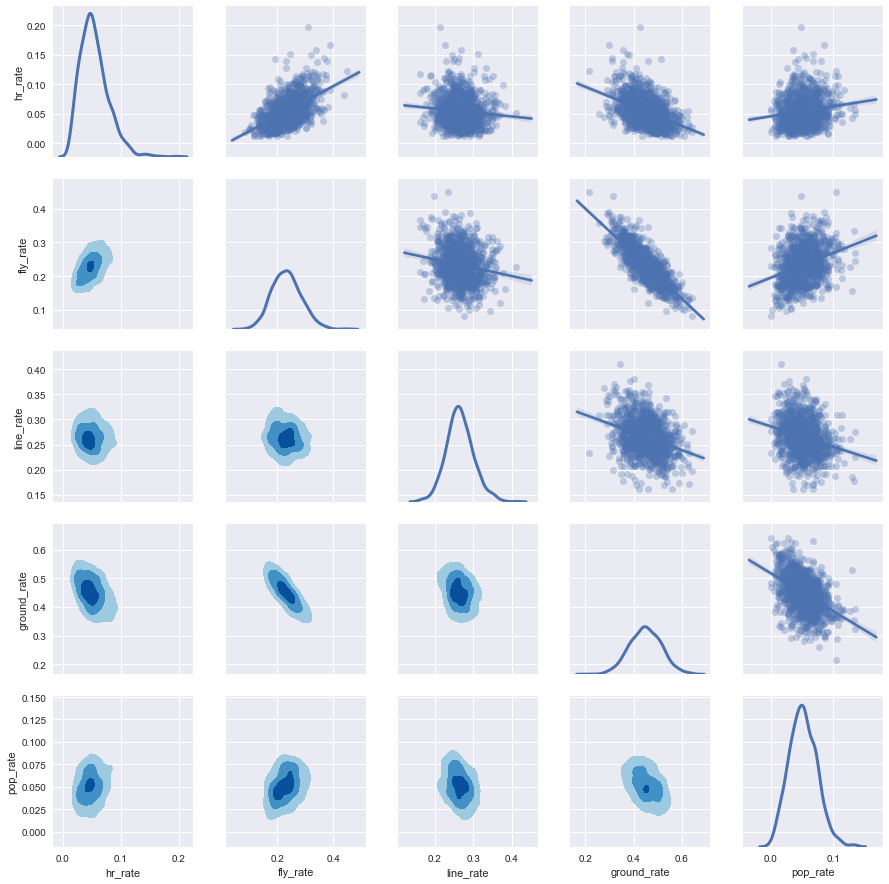

In [11]:
basic_pair_columns = [
    'hr_rate',
    'fly_rate',
    'line_rate',
    'ground_rate',
    'pop_rate'
]
df_basic_pair = df_threshold[basic_pair_columns]

basic_g = sns.PairGrid(df_basic_pair)
basic_g = basic_g.map_upper(sns.regplot, scatter_kws={'alpha': 0.3})
basic_g = basic_g.map_lower(sns.kdeplot, cmap='Blues', shade=True, shade_lowest=False, n_levels=3)
basic_g = basic_g.map_diag(sns.kdeplot, lw=3, legend=False)

/Users/ad/Documents/projects/mlb-db-analysis/venv/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


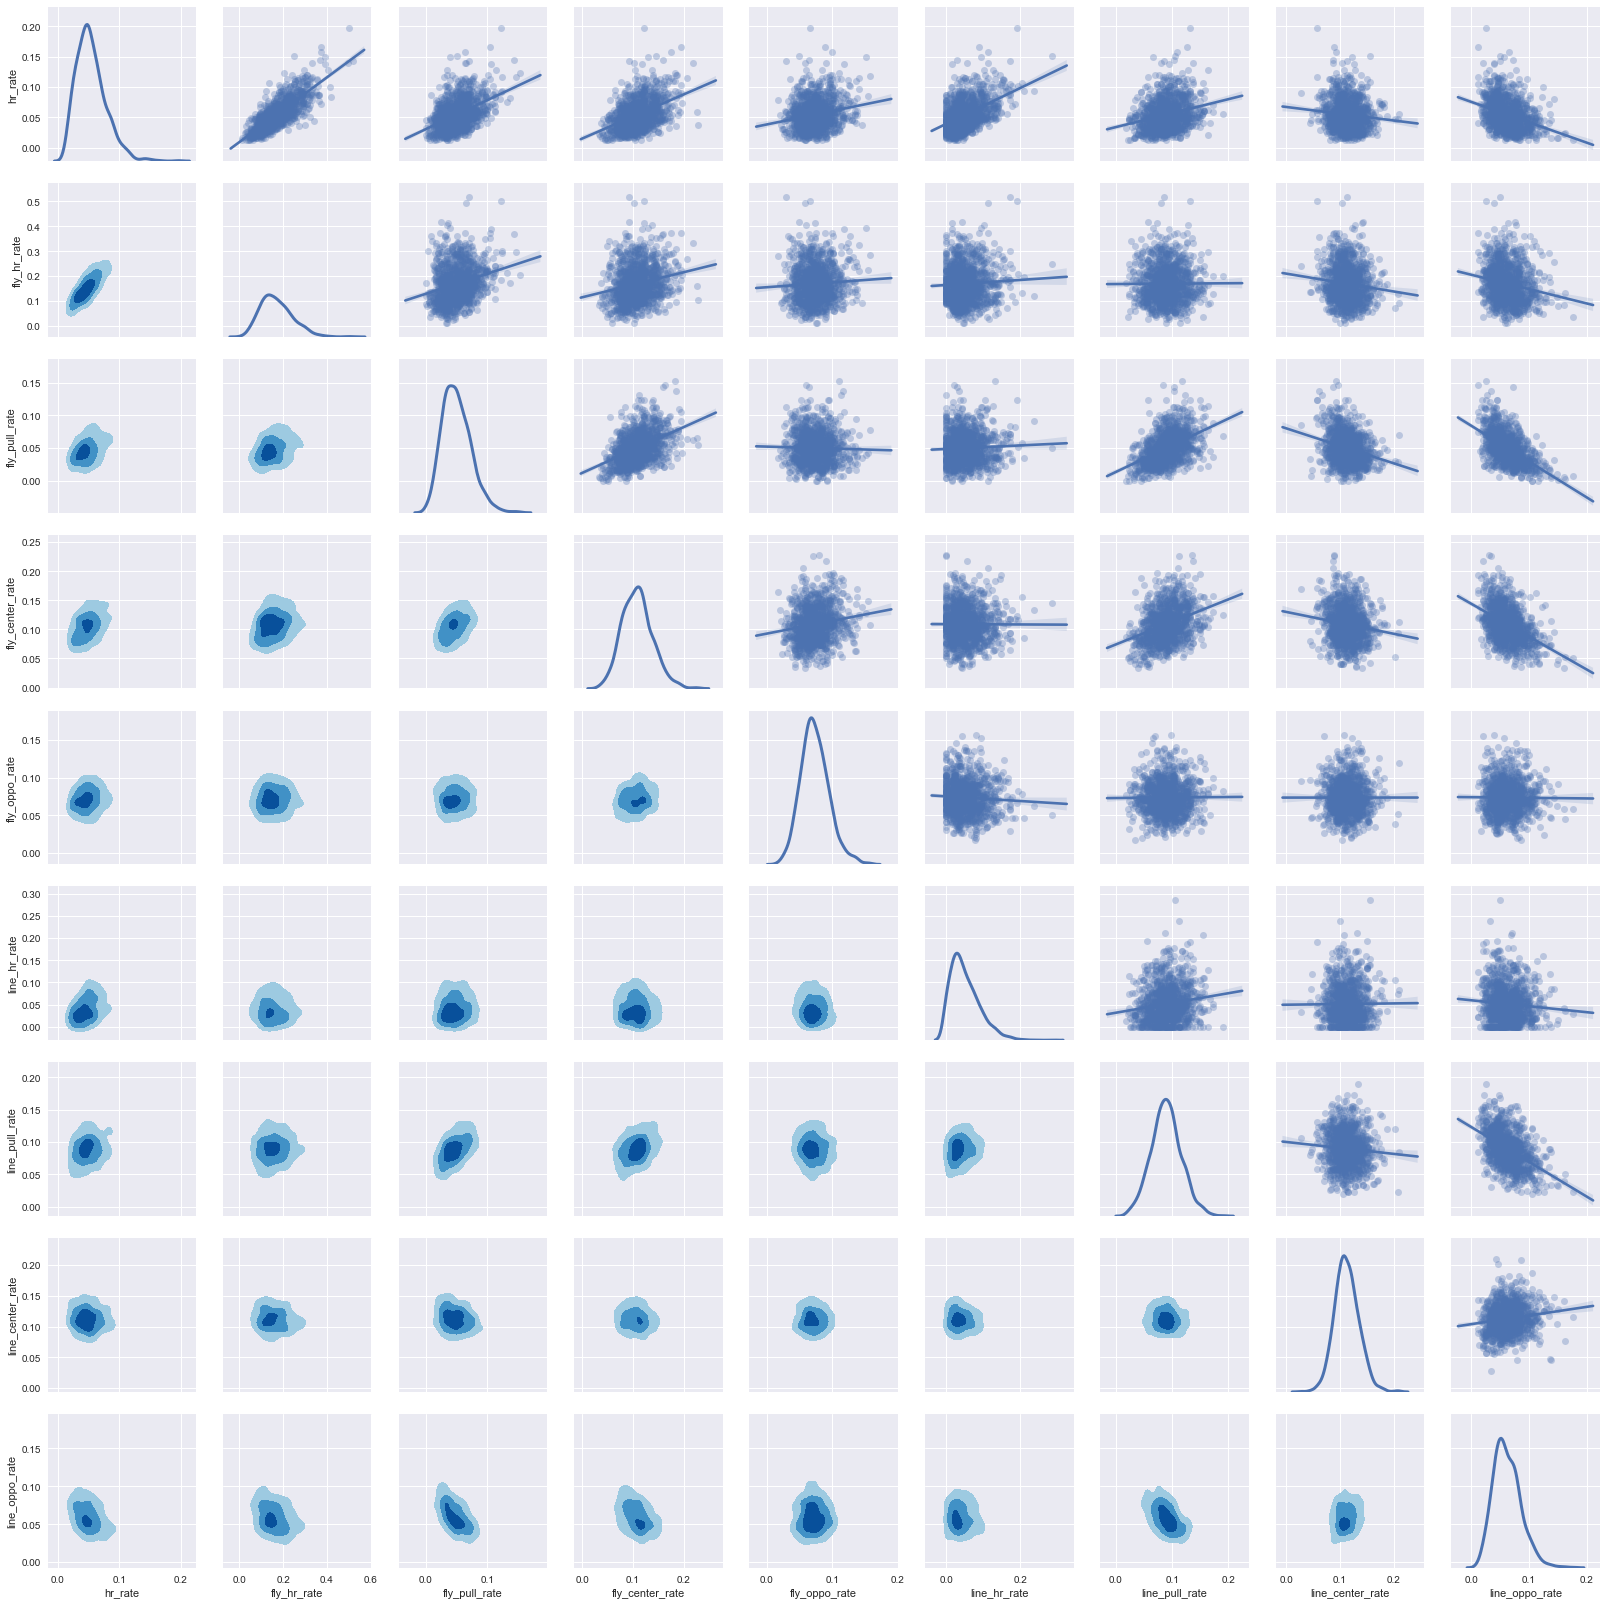

In [12]:
dir_pair_columns = [
    'hr_rate',
    'fly_hr_rate',
    'fly_pull_rate',
    'fly_center_rate',
    'fly_oppo_rate',
    'line_hr_rate',
    'line_pull_rate',
    'line_center_rate',
    'line_oppo_rate'
]
df_dir_pair = df_threshold[dir_pair_columns]

dir_g = sns.PairGrid(df_dir_pair)
dir_g = dir_g.map_upper(sns.regplot, scatter_kws={'alpha': 0.3})
dir_g = dir_g.map_lower(sns.kdeplot, cmap='Blues', shade=True, shade_lowest=False, n_levels=3)
dir_g = dir_g.map_diag(sns.kdeplot, lw=3, legend=False)

/Users/ad/Documents/projects/mlb-db-analysis/venv/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


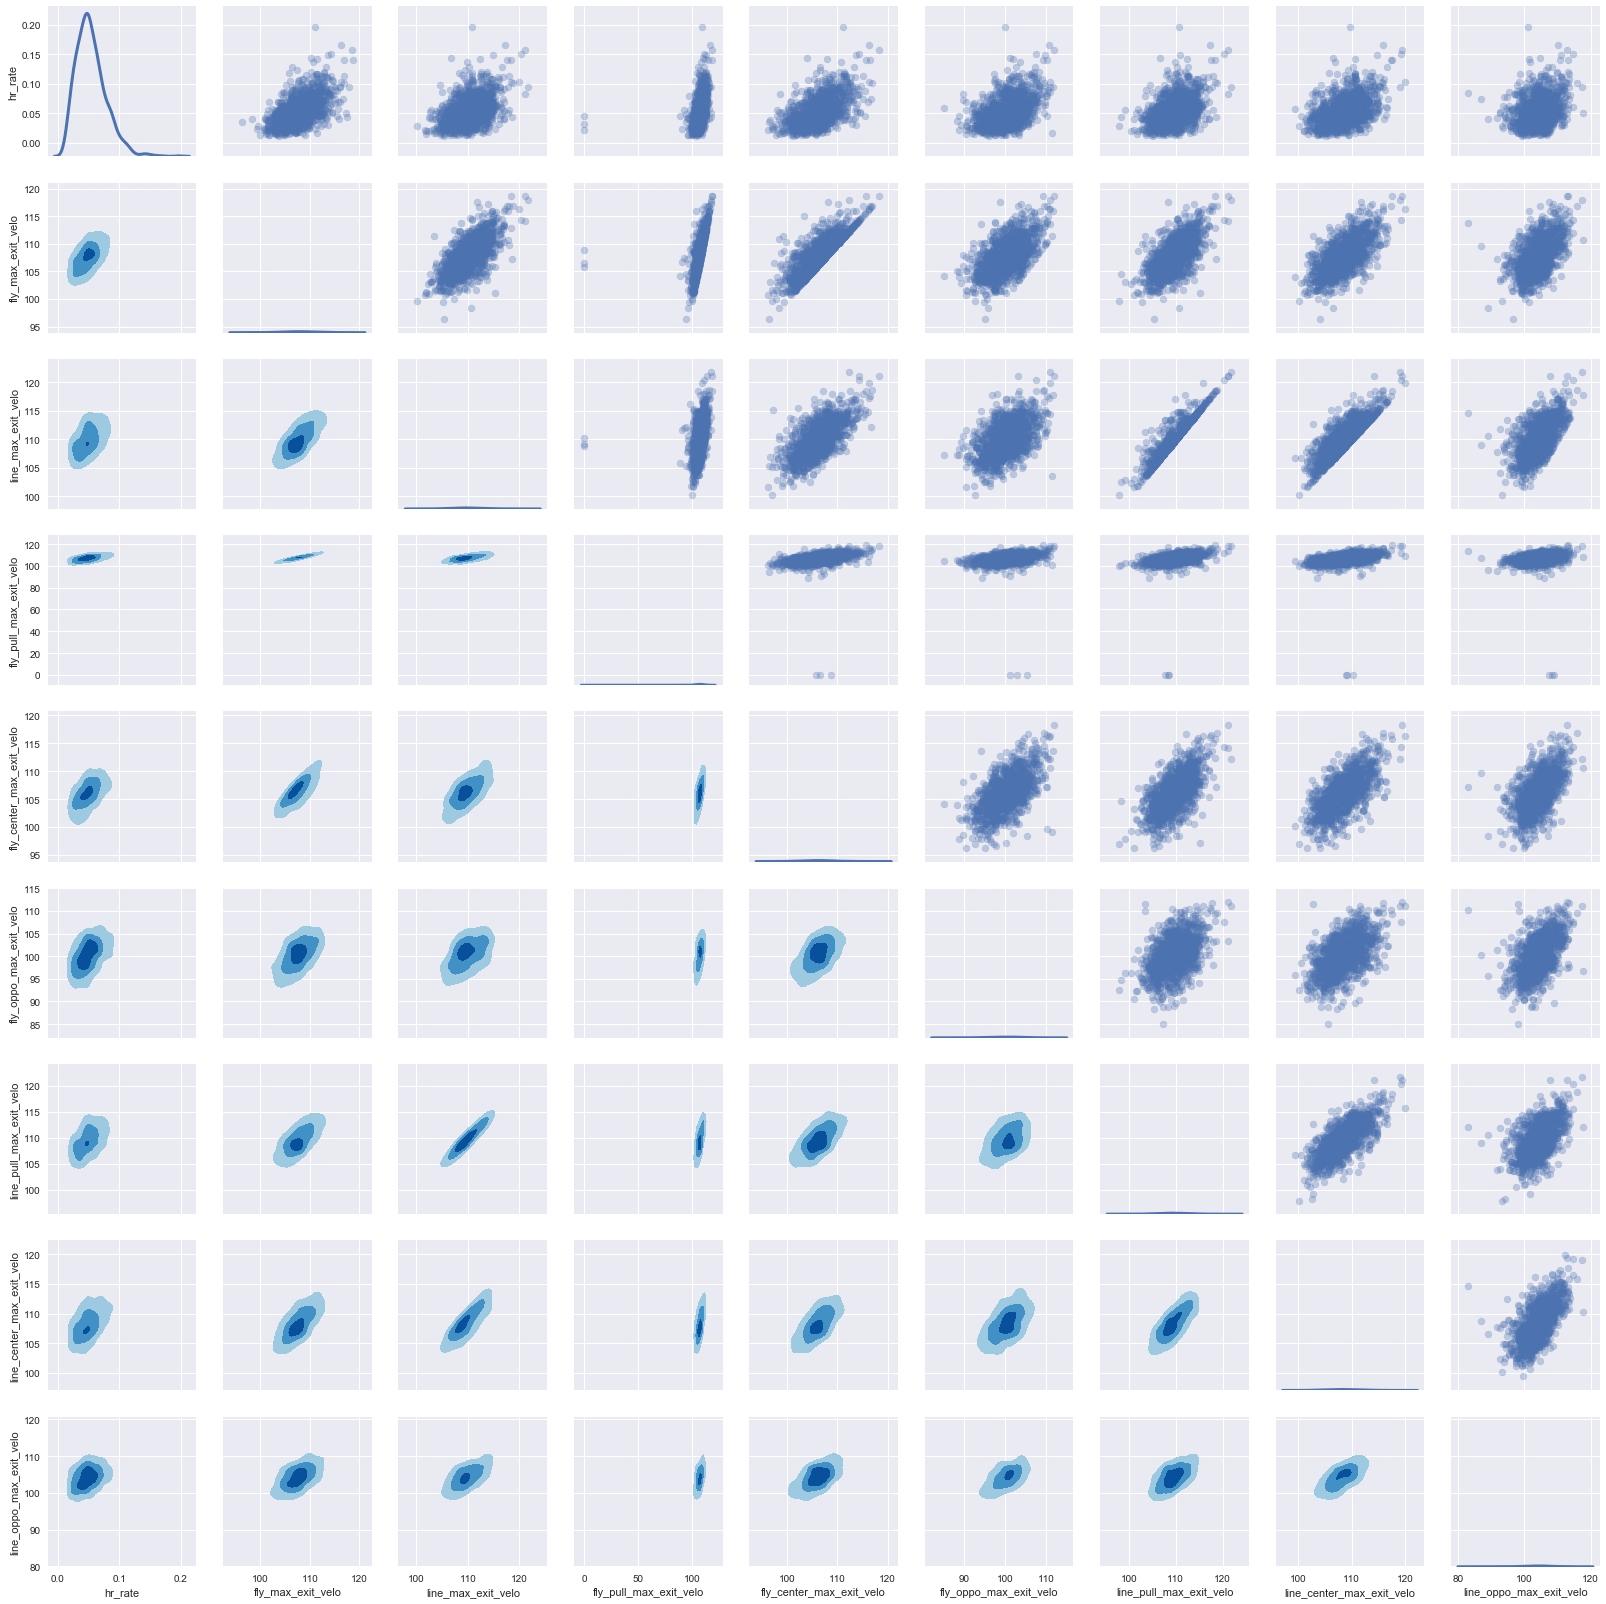

In [13]:
max_velo_pair_columns = [
    'hr_rate',
    'fly_max_exit_velo',
    'line_max_exit_velo',
    'fly_pull_max_exit_velo',
    'fly_center_max_exit_velo',
    'fly_oppo_max_exit_velo',
    'line_pull_max_exit_velo',
    'line_center_max_exit_velo',
    'line_oppo_max_exit_velo'
]
df_max_velo_pair = df_threshold[max_velo_pair_columns]
df_max_velo_pair = df_max_velo_pair.dropna()

max_velo_g = sns.PairGrid(df_max_velo_pair)
max_velo_g = max_velo_g.map_upper(plt.scatter, alpha=0.3)
max_velo_g = max_velo_g.map_lower(sns.kdeplot, cmap='Blues', shade=True, shade_lowest=False, n_levels=3)
max_velo_g = max_velo_g.map_diag(sns.kdeplot, lw=3, legend=False)

/Users/ad/Documents/projects/mlb-db-analysis/venv/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


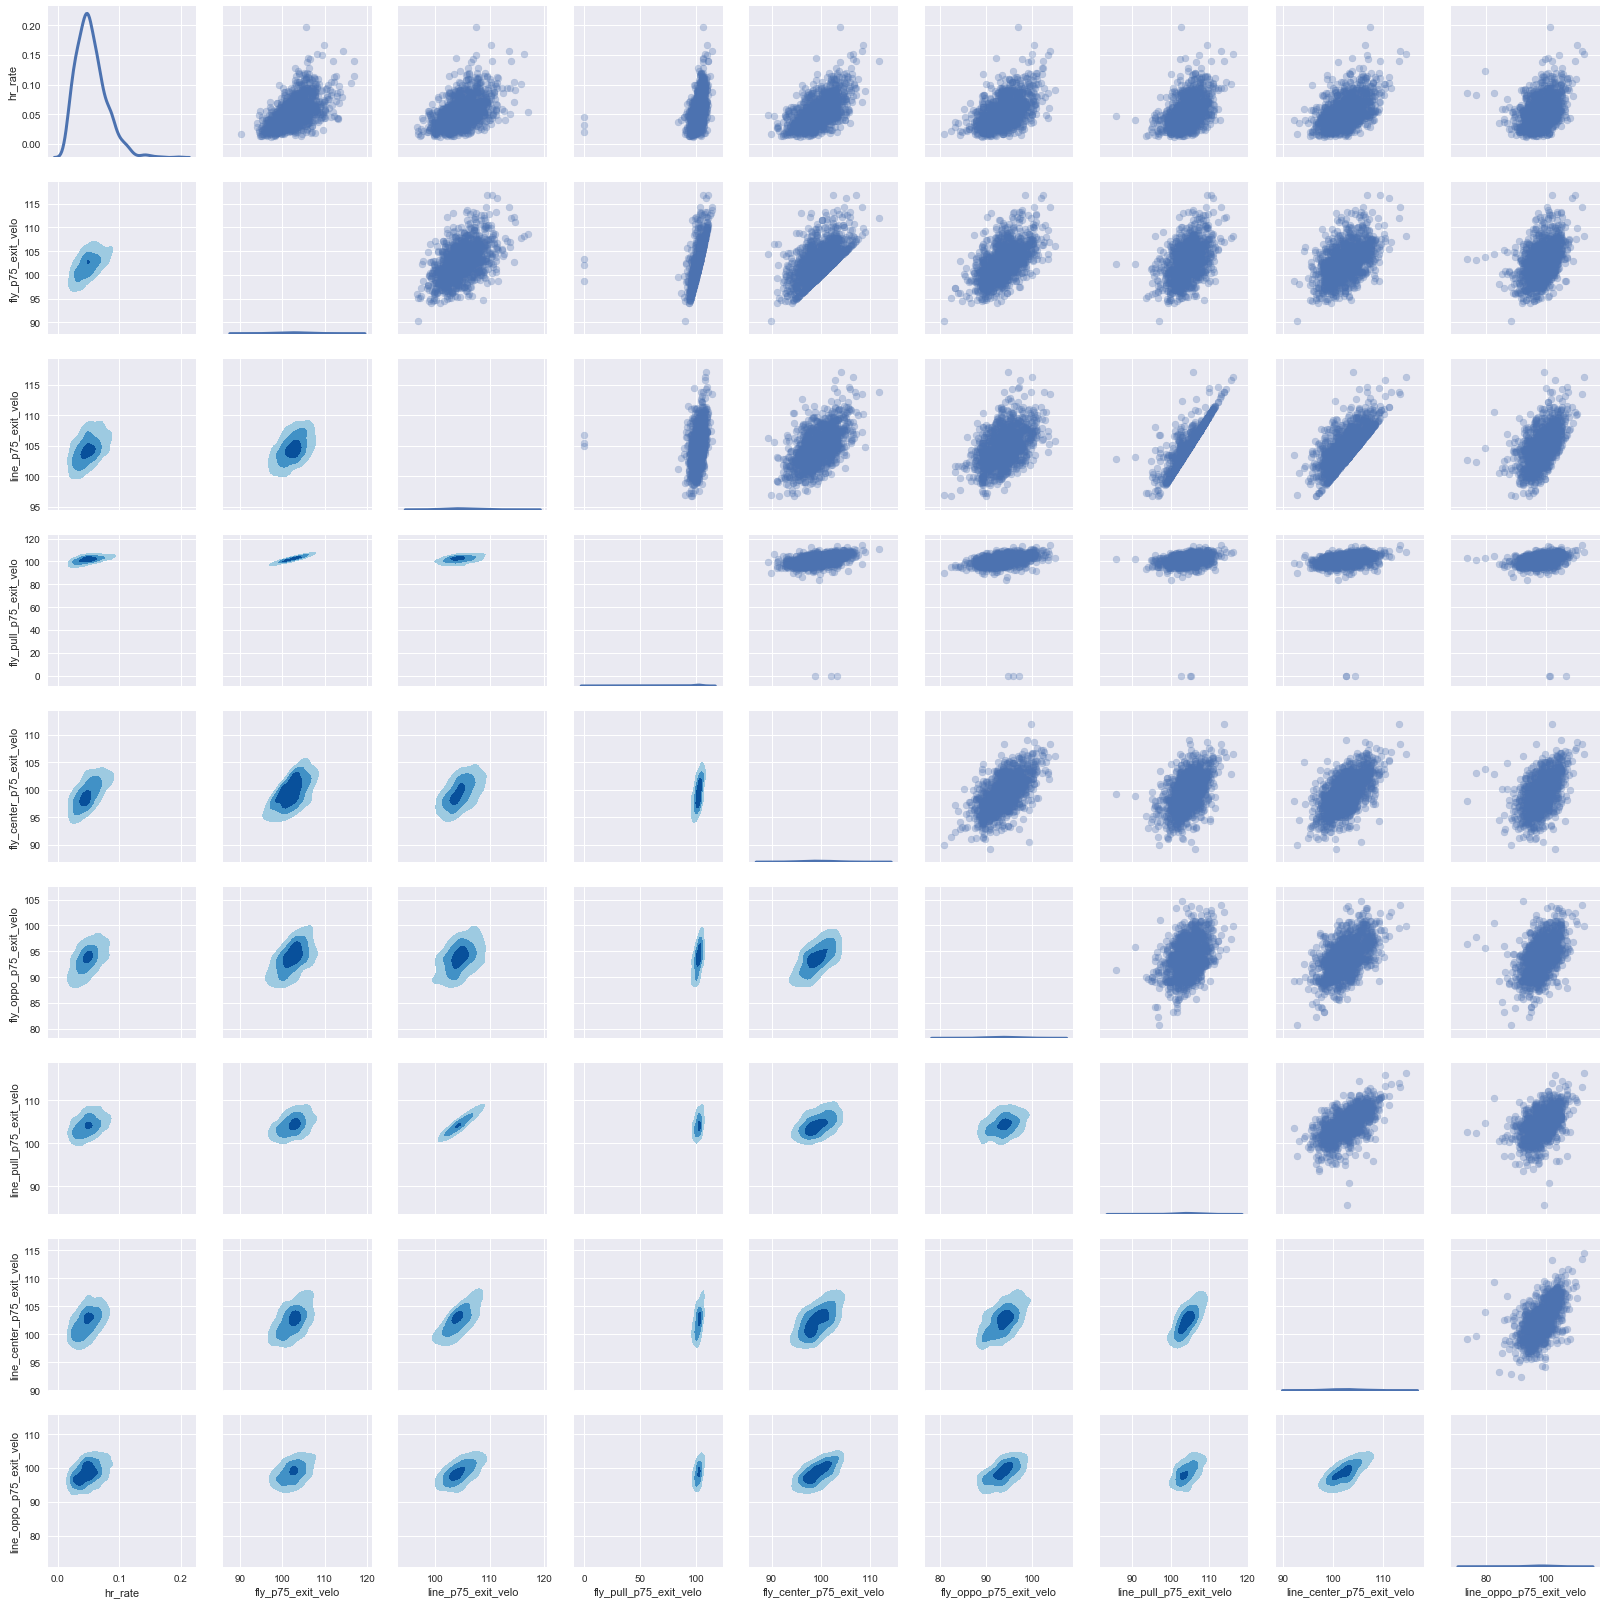

In [14]:
p75_velo_pair_columns = [
    'hr_rate',
    'fly_p75_exit_velo',
    'line_p75_exit_velo',
    'fly_pull_p75_exit_velo',
    'fly_center_p75_exit_velo',
    'fly_oppo_p75_exit_velo',
    'line_pull_p75_exit_velo',
    'line_center_p75_exit_velo',
    'line_oppo_p75_exit_velo'
]
df_p75_velo_pair = df_threshold[p75_velo_pair_columns]
df_p75_velo_pair = df_p75_velo_pair.dropna()

p75_velo_g = sns.PairGrid(df_p75_velo_pair)
p75_velo_g = p75_velo_g.map_upper(plt.scatter, alpha=0.3)
p75_velo_g = p75_velo_g.map_lower(sns.kdeplot, cmap='Blues', shade=True, shade_lowest=False, n_levels=3)
p75_velo_g = p75_velo_g.map_diag(sns.kdeplot, lw=3, legend=False)

/Users/ad/Documents/projects/mlb-db-analysis/venv/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


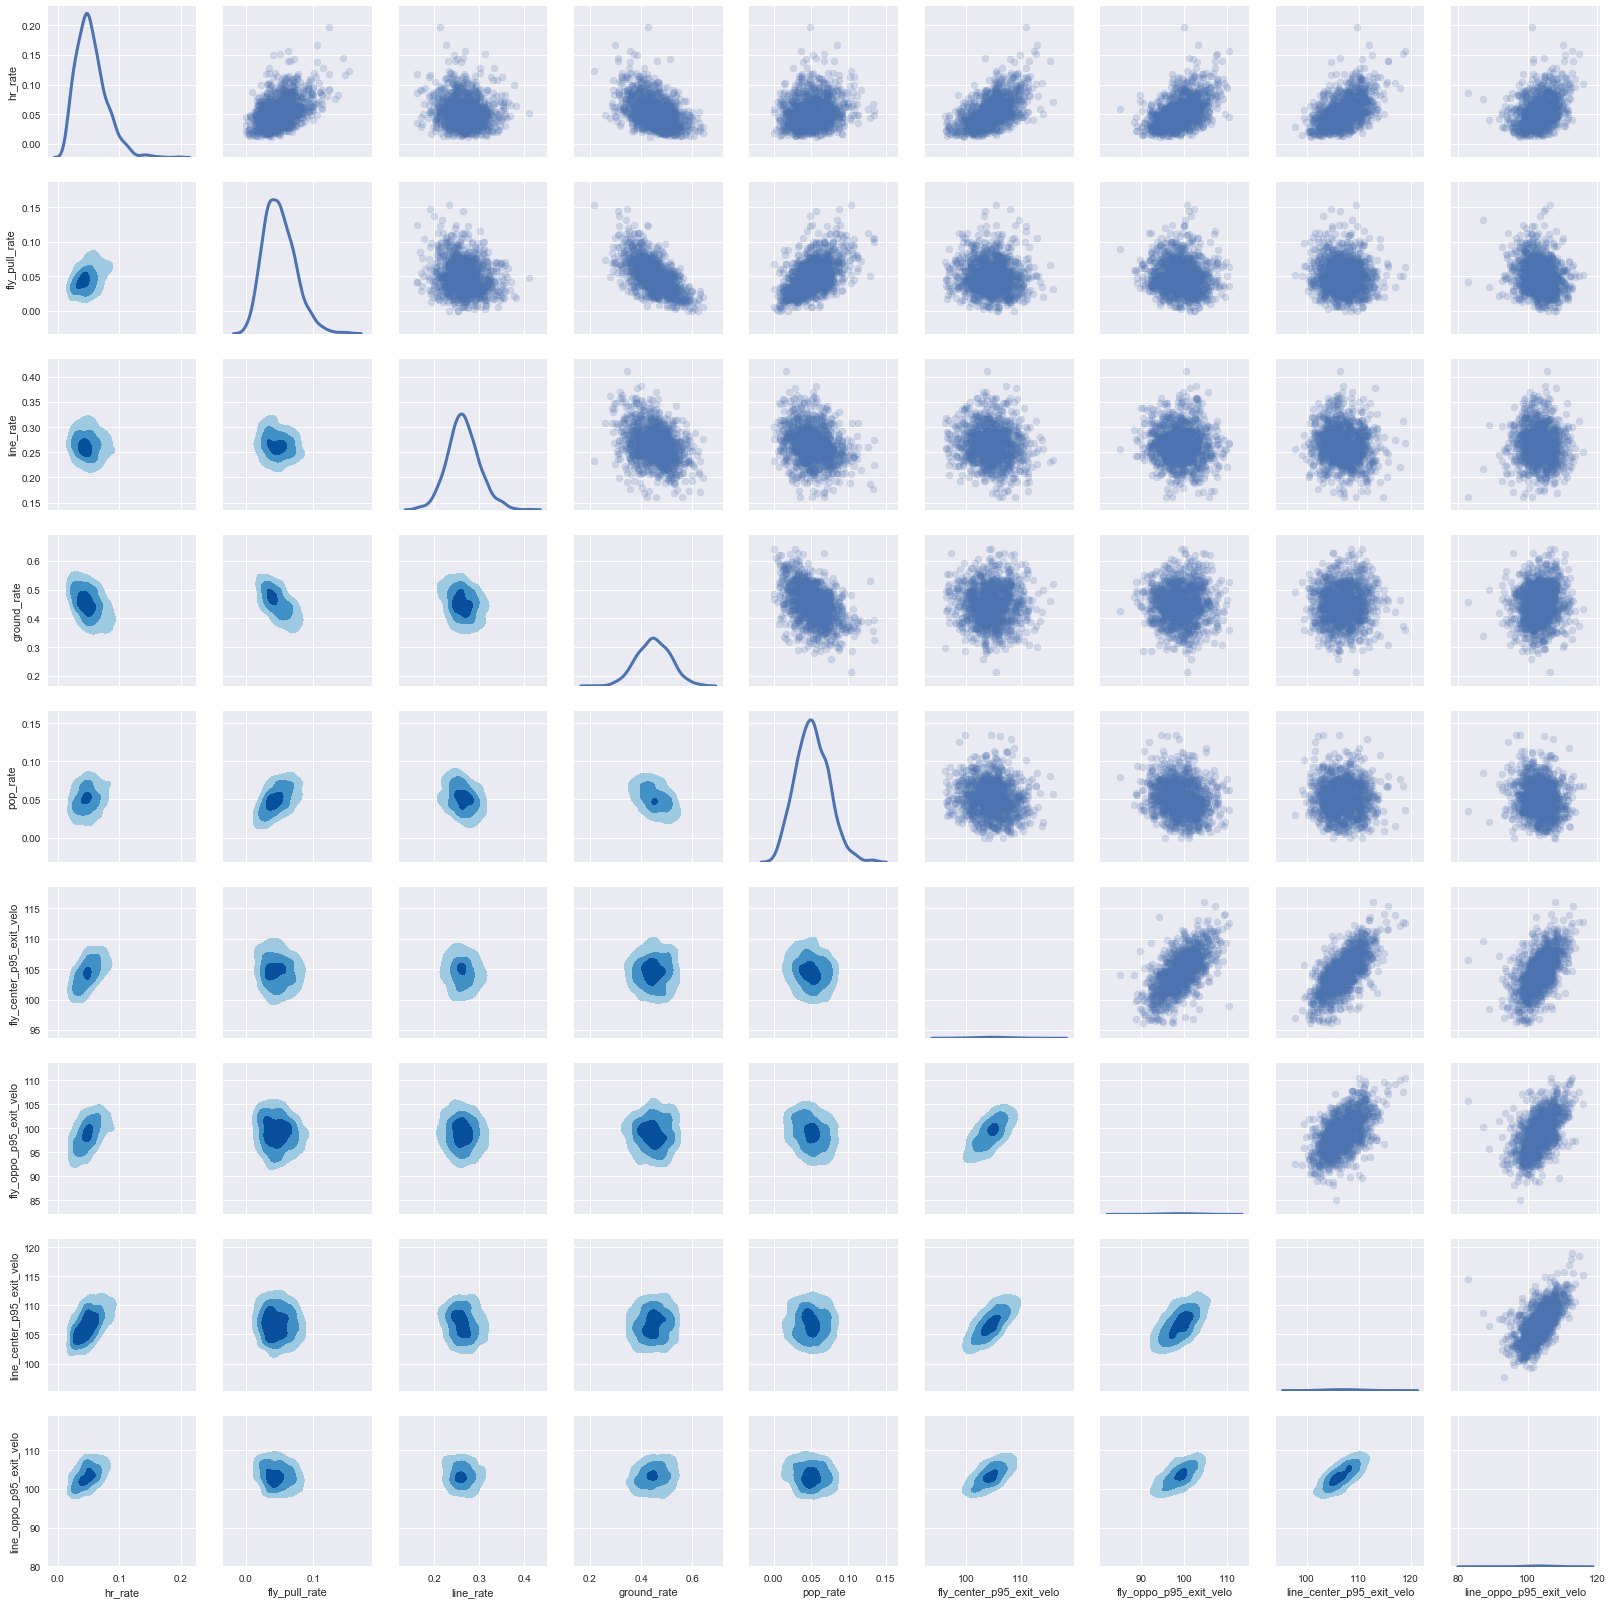

In [15]:
final_pair_columns = [
    'hr_rate',
    'fly_pull_rate',
    'line_rate',
    'ground_rate',
    'pop_rate',
    'fly_center_p95_exit_velo',
    'fly_oppo_p95_exit_velo',
    'line_center_p95_exit_velo',
    'line_oppo_p95_exit_velo'
]

df_final_pair = df_threshold[final_pair_columns]
df_final_pair = df_final_pair.dropna()

final_g = sns.PairGrid(df_final_pair)
final_g = final_g.map_upper(plt.scatter, alpha=0.2)
final_g = final_g.map_lower(sns.kdeplot, cmap='Blues', shade=True, shade_lowest=False, n_levels=3)
final_g = final_g.map_diag(sns.kdeplot, lw=3, legend=False)

## Modeling
Predicting HR rate based on a variety of inputs

In [16]:
def train_and_evaluate_model(
        df,
        label,
        features,
        model,
        scaler,
        preprocessing=True,
        test_size=0.20
    ):
    
    # Train model
    y = df[label]
    X = df[features]
    
    if preprocessing:
        try:
            X = scaler.fit_transform(X)
        except:
            print("Error:", sys.exc_info()[0])
            raise
        
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42)
    
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test)
    
    # Model description
    model_name = type(model).__name__
    
    if model_name in ['LinearRegression', 'ElasticNet', 'LinearSVR']:
        print('MODEL COEFFICIENTS FOR {:s} MODEL'.format(model_name))
        print("{:30}[{:5.3f}]".format('Intercept:', model.intercept_))
        for feature, weight in list(zip(features, model.coef_)):
            print("{:30}[{:5.4f}]".format(feature + ":", weight))
        print('\n')
            
    elif model_name == 'AdaBoostRegressor':
        print('MODEL FEARURE FOR {:s} MODEL'.format(model_name))
        for feature, importance in list(zip(features, model.feature_importances_)):
            print("{:30}[{:5.4f}]".format(feature + ":", importance))
        print('\n')
    
    # Model metrics
    evs = explained_variance_score(y_true=y_test, y_pred=y_pred)
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    
    print('MODEL METRICS FOR {:s} MODEL'.format(model_name))
    print('Explained Variance Score: {:5.4f}'.format(evs))
    print('Mean Absolute Error: {:5.4f}'.format(mae))
    print('Mean Squared Error: {:5.4f}'.format(mse))
    print('R-Squared: {:5.4f}'.format(r2))
    
    # Residuals plot
    resid_plot = ResidualsPlot(model)
    resid_plot.fit(X_train, y_train)
    resid_plot.score(X_test, y_test)
    resid_plot.poof()
    
    # Prediction error plot
    y_min = np.min(y_test)
    y_max = np.max(y_test)
    y_range = y_max - y_min
    y_limits = (y_min - 0.1 * y_range, y_max + 0.1 * y_range)

    ax = plt.axes()    
    
    pred_plot = PredictionError(model, ax=ax)
    pred_plot.score(X_test, y_test)    
    
    ax.set_xlim(y_limits)
    ax.set_ylim(y_limits)
    
    pred_plot.poof()

### Linear regression (basic features)

/Users/ad/Documents/projects/mlb-db-analysis/venv/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


MODEL COEFFICIENTS FOR LinearRegression MODEL
Intercept:                    [0.000]
fly_rate:                     [0.1044]
line_rate:                    [0.0061]
ground_rate:                  [0.0146]
pop_rate:                     [0.0010]


MODEL METRICS FOR LinearRegression MODEL
Explained Variance Score: 0.3164
Mean Absolute Error: 0.0159
Mean Squared Error: 0.0004
R-Squared: 0.3111


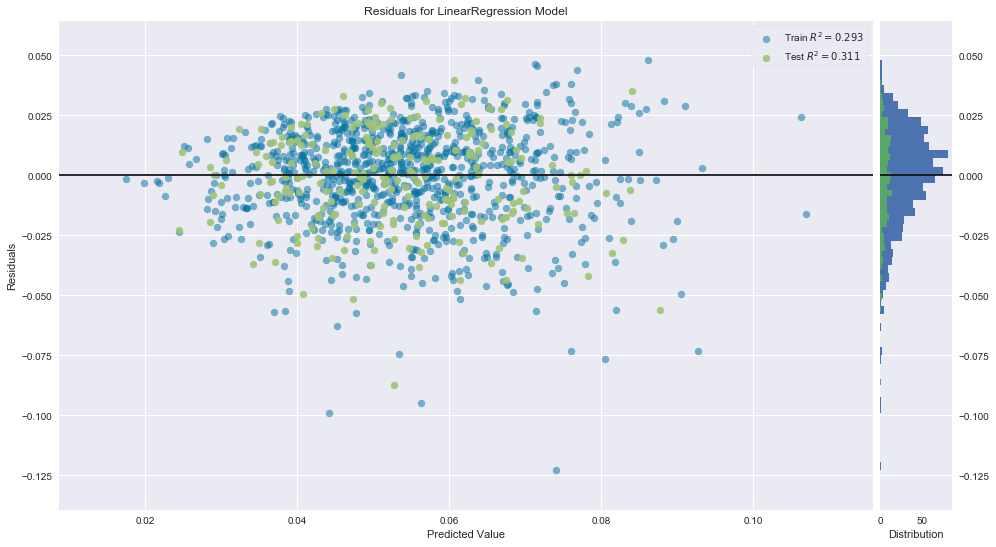

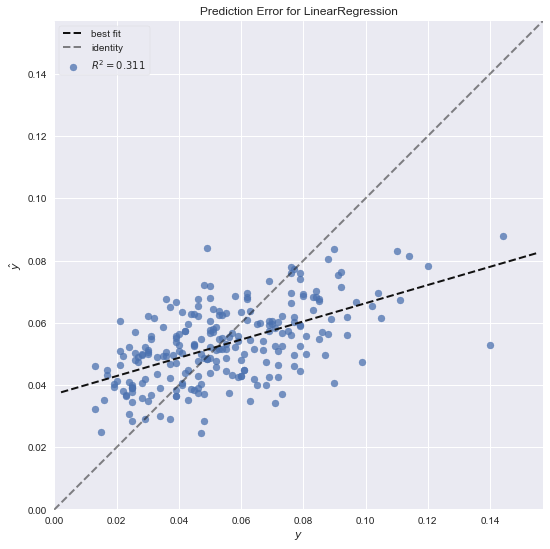

In [17]:
lr_label = 'hr_rate'
lr_features_1 = ['fly_rate', 'line_rate', 'ground_rate', 'pop_rate']

lr_1 = LinearRegression(fit_intercept=False, copy_X=True)
lr_scaler_1 = MinMaxScaler()

train_and_evaluate_model(df=df_threshold, label=lr_label, features=lr_features_1, model=lr_1, scaler=lr_scaler_1)

### Linear regression (directional features)

MODEL COEFFICIENTS FOR LinearRegression MODEL
Intercept:                    [0.000]
fly_pull_rate:                [0.0554]
fly_center_rate:              [0.0432]
fly_oppo_rate:                [0.0294]
line_pull_rate:               [0.0022]
line_center_rate:             [0.0059]
line_oppo_rate:               [-0.0062]
ground_rate:                  [0.0100]


MODEL METRICS FOR LinearRegression MODEL
Explained Variance Score: 0.3320
Mean Absolute Error: 0.0157
Mean Squared Error: 0.0004
R-Squared: 0.3288


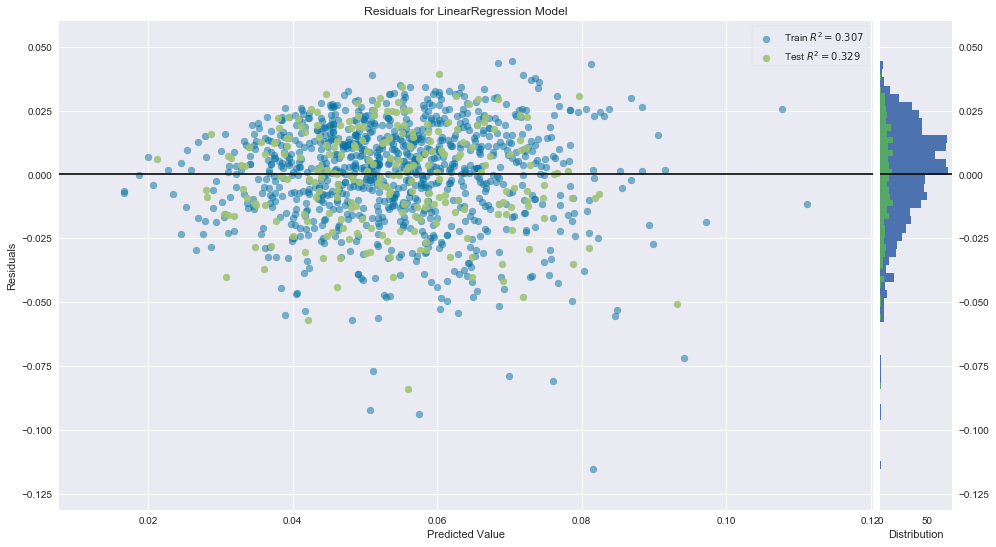

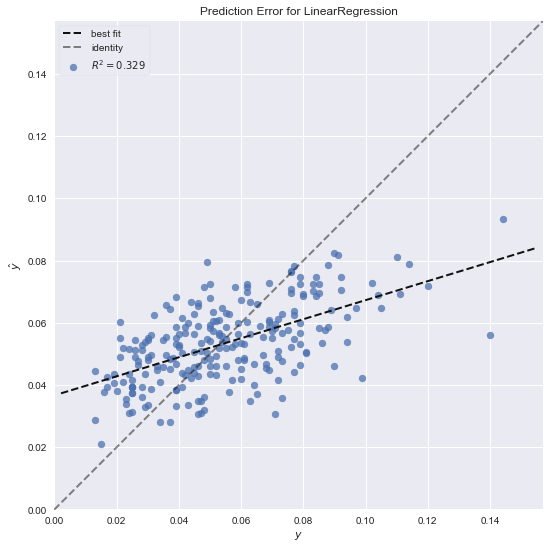

In [18]:
lr_label = 'hr_rate'
lr_features_2 = [
    'fly_pull_rate',
    'fly_center_rate',
    'fly_oppo_rate',
    'line_pull_rate',
    'line_center_rate',
    'line_oppo_rate',
    'ground_rate'
]

lr_2 = LinearRegression(fit_intercept=False, copy_X=True)
lr_scaler_2 = MinMaxScaler()

train_and_evaluate_model(df=df_threshold, label=lr_label, features=lr_features_2, model=lr_2, scaler=lr_scaler_2)

### Linear regression (basic velocity features)

MODEL COEFFICIENTS FOR LinearRegression MODEL
Intercept:                    [0.000]
fly_max_exit_velo:            [0.0861]
line_max_exit_velo:           [0.0539]
ground_max_exit_velo:         [-0.0363]


MODEL METRICS FOR LinearRegression MODEL
Explained Variance Score: 0.3578
Mean Absolute Error: 0.0147
Mean Squared Error: 0.0004
R-Squared: 0.3555


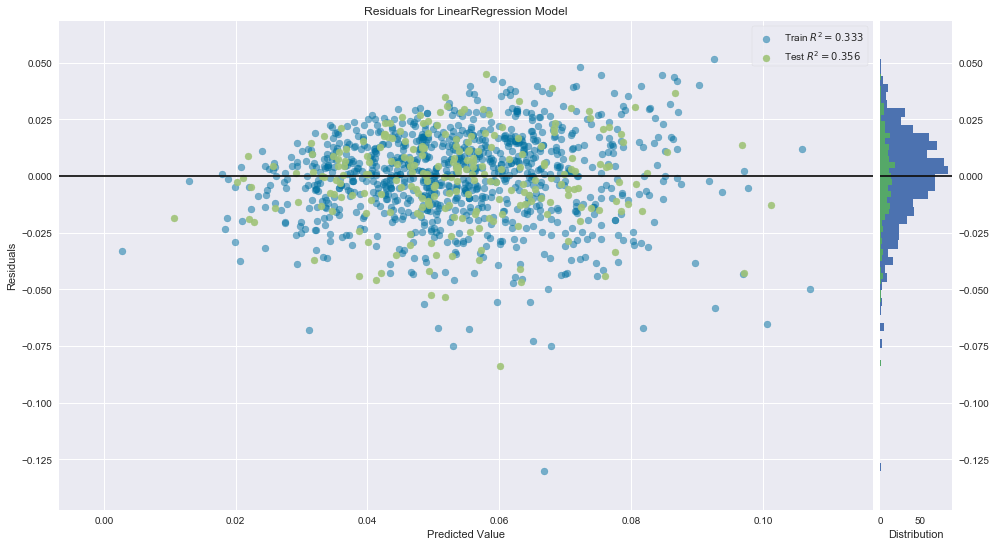

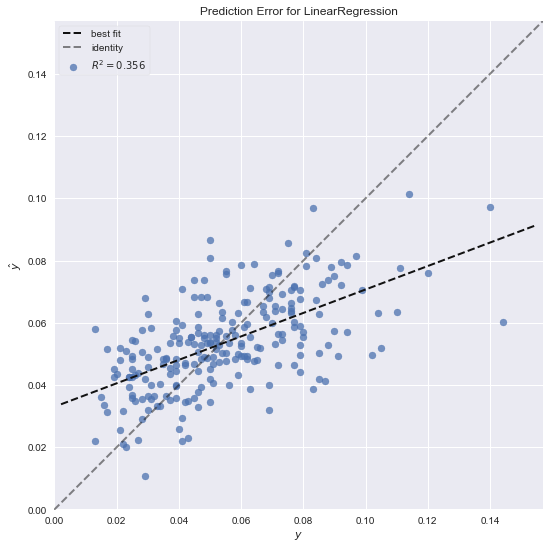

In [19]:
lr_label = 'hr_rate'
lr_features_3 = [
    'fly_max_exit_velo',
    'line_max_exit_velo',
    'ground_max_exit_velo'
]

lr_3 = LinearRegression(fit_intercept=False, copy_X=True)
lr_scaler_3 = MinMaxScaler()

train_and_evaluate_model(df=df_threshold, label=lr_label, features=lr_features_3, model=lr_3, scaler=lr_scaler_3)

### Linear regression (directional velocity features)

MODEL COEFFICIENTS FOR LinearRegression MODEL
Intercept:                    [0.000]
fly_pull_max_exit_velo:       [0.0204]
fly_center_max_exit_velo:     [0.0619]
fly_oppo_max_exit_velo:       [0.0266]
line_pull_max_exit_velo:      [0.0253]
line_center_max_exit_velo:    [0.0324]
line_oppo_max_exit_velo:      [-0.0304]
ground_max_exit_velo:         [-0.0355]


MODEL METRICS FOR LinearRegression MODEL
Explained Variance Score: 0.3725
Mean Absolute Error: 0.0144
Mean Squared Error: 0.0004
R-Squared: 0.3725


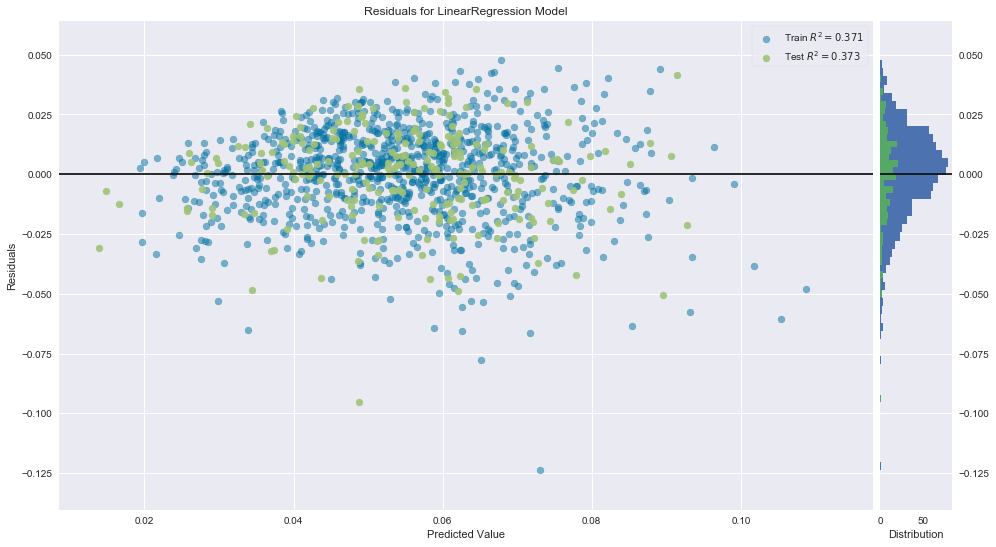

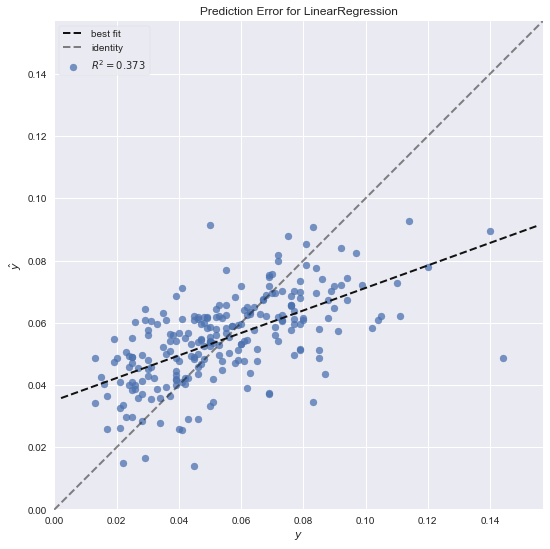

In [20]:
lr_label = 'hr_rate'
lr_features_4 = [
    'fly_pull_max_exit_velo',
    'fly_center_max_exit_velo',
    'fly_oppo_max_exit_velo',
    'line_pull_max_exit_velo',
    'line_center_max_exit_velo',
    'line_oppo_max_exit_velo',
    'ground_max_exit_velo'
]

lr_4 = LinearRegression(fit_intercept=False, copy_X=True)
lr_scaler_4 = MinMaxScaler()

train_and_evaluate_model(df=df_threshold, label=lr_label, features=lr_features_4, model=lr_4, scaler=lr_scaler_4)

### Linear regression (all features)

MODEL COEFFICIENTS FOR LinearRegression MODEL
Intercept:                    [0.000]
fly_pull_rate:                [0.0647]
fly_center_rate:              [0.0047]
fly_oppo_rate:                [0.0030]
line_pull_rate:               [-0.0007]
line_center_rate:             [-0.0032]
line_oppo_rate:               [-0.0169]
ground_rate:                  [-0.0267]
pop_rate:                     [-0.0165]
fly_pull_max_exit_velo:       [0.0013]
fly_center_max_exit_velo:     [0.0397]
fly_oppo_max_exit_velo:       [0.0285]
line_pull_max_exit_velo:      [0.0039]
line_center_max_exit_velo:    [0.0313]
line_oppo_max_exit_velo:      [0.0144]
ground_max_exit_velo:         [-0.0038]


MODEL METRICS FOR LinearRegression MODEL
Explained Variance Score: 0.6334
Mean Absolute Error: 0.0114
Mean Squared Error: 0.0002
R-Squared: 0.6332


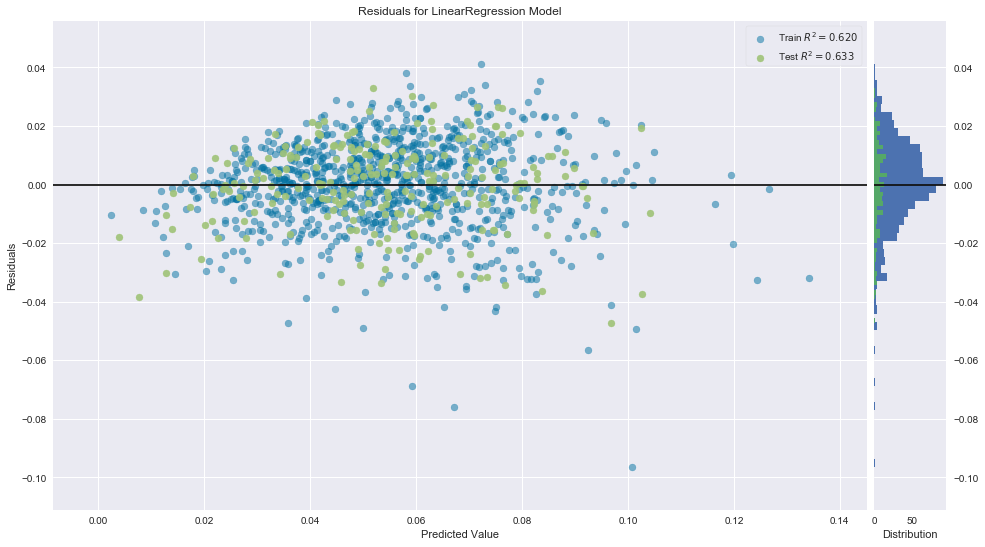

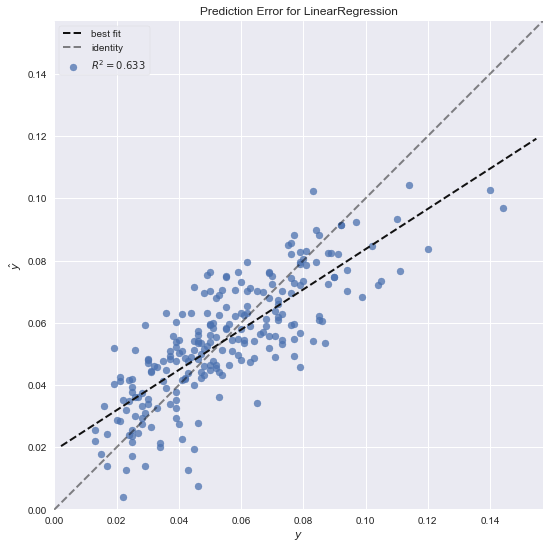

In [21]:
lr_label = 'hr_rate'
lr_features_5 = [
    'fly_pull_rate',
    'fly_center_rate',
    'fly_oppo_rate',
    'line_pull_rate',
    'line_center_rate',
    'line_oppo_rate',
    'ground_rate',
    'pop_rate',
    'fly_pull_max_exit_velo',
    'fly_center_max_exit_velo',
    'fly_oppo_max_exit_velo',
    'line_pull_max_exit_velo',
    'line_center_max_exit_velo',
    'line_oppo_max_exit_velo',
    'ground_max_exit_velo'
]

lr_5 = LinearRegression(fit_intercept=False, copy_X=True)
lr_scaler_5 = MinMaxScaler()

train_and_evaluate_model(df=df_threshold, label=lr_label, features=lr_features_5, model=lr_5, scaler=lr_scaler_5)

### Linear Regression (all features using 95th percentile velocities)

MODEL COEFFICIENTS FOR LinearRegression MODEL
Intercept:                    [0.000]
fly_pull_rate:                [0.0614]
fly_center_rate:              [0.0026]
fly_oppo_rate:                [0.0011]
line_pull_rate:               [-0.0013]
line_center_rate:             [-0.0025]
line_oppo_rate:               [-0.0159]
ground_rate:                  [-0.0350]
pop_rate:                     [-0.0179]
fly_pull_p95_exit_velo:       [0.0086]
fly_center_p95_exit_velo:     [0.0418]
fly_oppo_p95_exit_velo:       [0.0258]
line_pull_p95_exit_velo:      [0.0020]
line_center_p95_exit_velo:    [0.0322]
line_oppo_p95_exit_velo:      [0.0136]
ground_p95_exit_velo:         [0.0058]


MODEL METRICS FOR LinearRegression MODEL
Explained Variance Score: 0.6735
Mean Absolute Error: 0.0105
Mean Squared Error: 0.0002
R-Squared: 0.6735


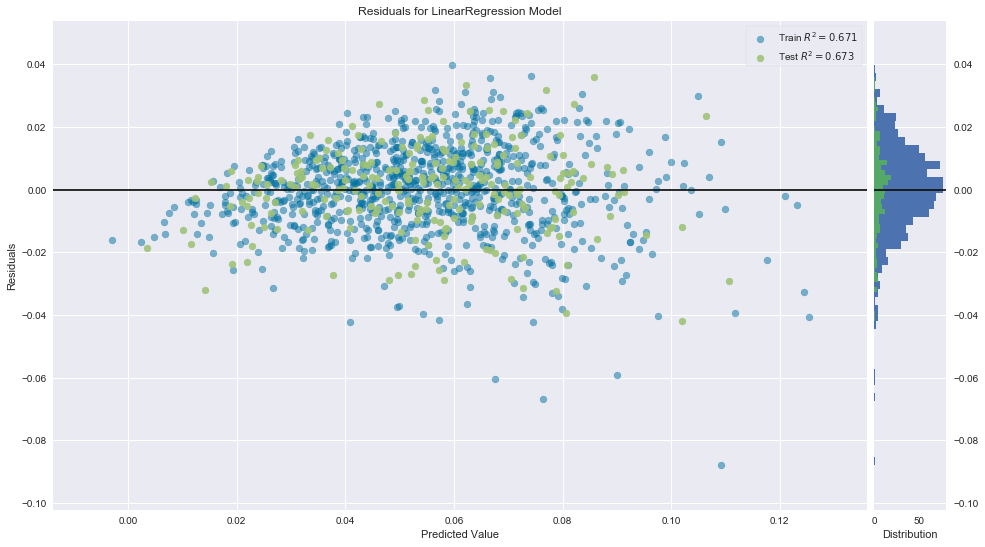

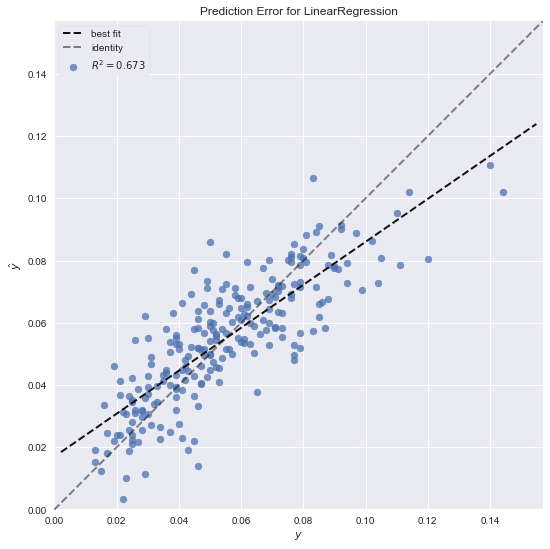

In [22]:
lr_label = 'hr_rate'
lr_features_6 = [
    'fly_pull_rate',
    'fly_center_rate',
    'fly_oppo_rate',
    'line_pull_rate',
    'line_center_rate',
    'line_oppo_rate',
    'ground_rate',
    'pop_rate',
    'fly_pull_p95_exit_velo',
    'fly_center_p95_exit_velo',
    'fly_oppo_p95_exit_velo',
    'line_pull_p95_exit_velo',
    'line_center_p95_exit_velo',
    'line_oppo_p95_exit_velo',
    'ground_p95_exit_velo'
]

lr_6 = LinearRegression(fit_intercept=False, copy_X=True)
lr_scaler_6 = MinMaxScaler()

train_and_evaluate_model(df=df_threshold, label=lr_label, features=lr_features_6, model=lr_6, scaler=lr_scaler_6)

### Elastic Net Regression (all features)

MODEL COEFFICIENTS FOR ElasticNet MODEL
Intercept:                    [0.054]
fly_pull_rate:                [0.0095]
fly_center_rate:              [0.0015]
fly_oppo_rate:                [0.0008]
line_pull_rate:               [0.0004]
line_center_rate:             [0.0000]
line_oppo_rate:               [-0.0013]
ground_rate:                  [-0.0023]
pop_rate:                     [-0.0010]
fly_pull_max_exit_velo:       [0.0000]
fly_center_max_exit_velo:     [0.0061]
fly_oppo_max_exit_velo:       [0.0044]
line_pull_max_exit_velo:      [0.0002]
line_center_max_exit_velo:    [0.0045]
line_oppo_max_exit_velo:      [0.0010]
ground_max_exit_velo:         [0.0000]


MODEL METRICS FOR ElasticNet MODEL
Explained Variance Score: 0.6326
Mean Absolute Error: 0.0114
Mean Squared Error: 0.0002
R-Squared: 0.6324


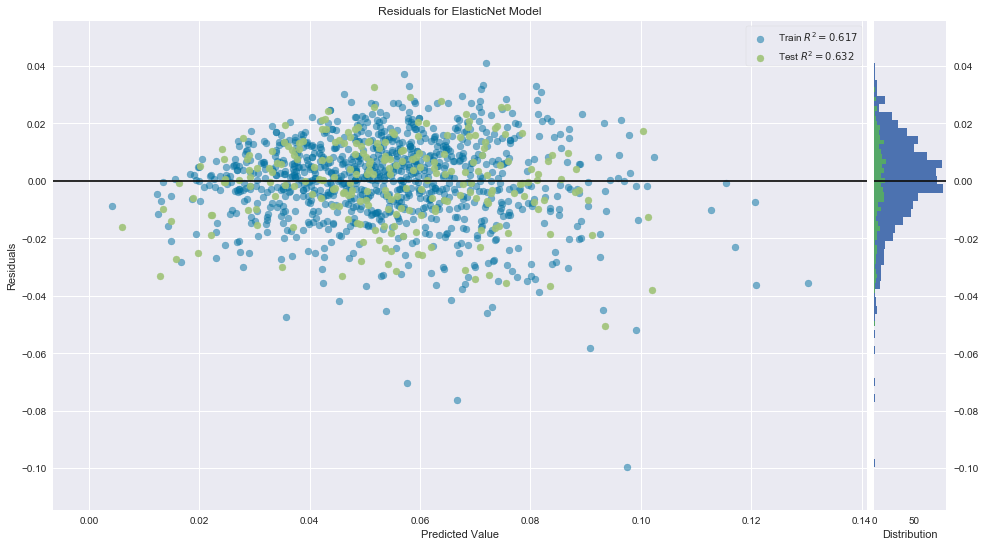

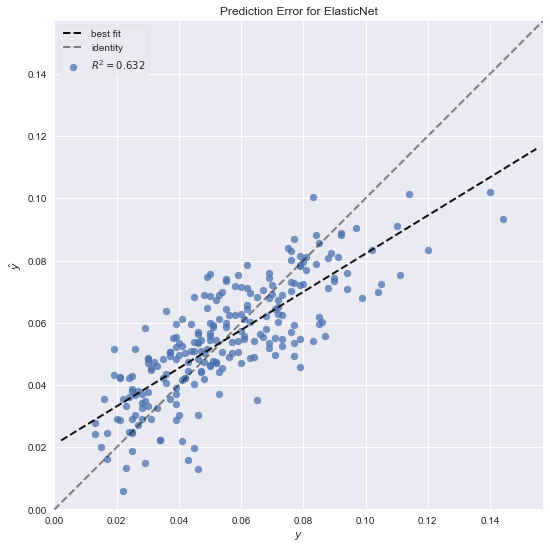

In [23]:
en_label = 'hr_rate'
en_features_1 = [
    'fly_pull_rate',
    'fly_center_rate',
    'fly_oppo_rate',
    'line_pull_rate',
    'line_center_rate',
    'line_oppo_rate',
    'ground_rate',
    'pop_rate',
    'fly_pull_max_exit_velo',
    'fly_center_max_exit_velo',
    'fly_oppo_max_exit_velo',
    'line_pull_max_exit_velo',
    'line_center_max_exit_velo',
    'line_oppo_max_exit_velo',
    'ground_max_exit_velo'
]

en_1 = ElasticNet(alpha=0.01, l1_ratio=0.05, fit_intercept=True, copy_X=True)
en_scaler_1 = StandardScaler()

train_and_evaluate_model(df=df_threshold, label=en_label, features=en_features_1, model=en_1, scaler=en_scaler_1)

### Elastic Net Regression (all features using 95th percentile velocities)

MODEL COEFFICIENTS FOR ElasticNet MODEL
Intercept:                    [0.054]
fly_pull_rate:                [0.0090]
fly_center_rate:              [0.0011]
fly_oppo_rate:                [0.0005]
line_pull_rate:               [0.0003]
line_center_rate:             [0.0000]
line_oppo_rate:               [-0.0013]
ground_rate:                  [-0.0035]
pop_rate:                     [-0.0011]
fly_pull_p95_exit_velo:       [0.0003]
fly_center_p95_exit_velo:     [0.0068]
fly_oppo_p95_exit_velo:       [0.0040]
line_pull_p95_exit_velo:      [0.0002]
line_center_p95_exit_velo:    [0.0046]
line_oppo_p95_exit_velo:      [0.0013]
ground_p95_exit_velo:         [0.0003]


MODEL METRICS FOR ElasticNet MODEL
Explained Variance Score: 0.6728
Mean Absolute Error: 0.0105
Mean Squared Error: 0.0002
R-Squared: 0.6728


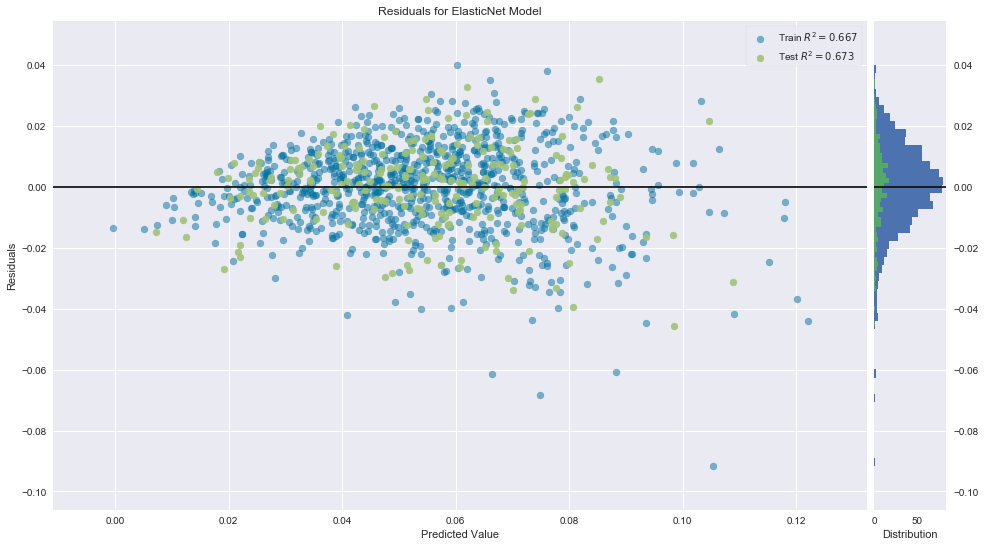

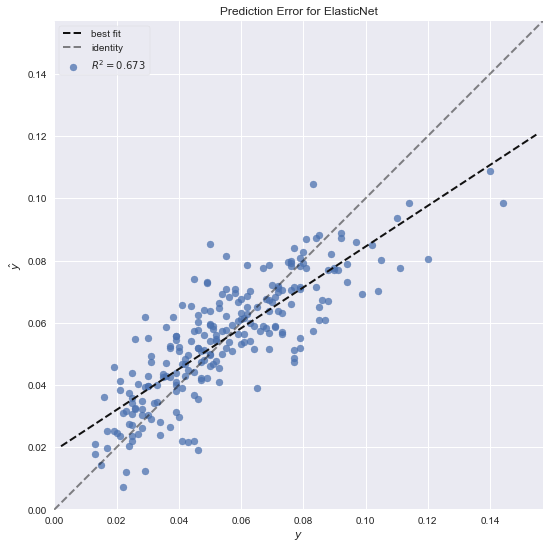

In [56]:
en_label = 'hr_rate'
en_features_2 = [
    'fly_pull_rate',
    'fly_center_rate',
    'fly_oppo_rate',
    'line_pull_rate',
    'line_center_rate',
    'line_oppo_rate',
    'ground_rate',
    'pop_rate',
    'fly_pull_p95_exit_velo',
    'fly_center_p95_exit_velo',
    'fly_oppo_p95_exit_velo',
    'line_pull_p95_exit_velo',
    'line_center_p95_exit_velo',
    'line_oppo_p95_exit_velo',
    'ground_p95_exit_velo'
]

en_2 = ElasticNet(alpha=0.01, l1_ratio=0.05, fit_intercept=True, copy_X=True)
en_scaler_2 = StandardScaler()

train_and_evaluate_model(df=df_threshold, label=en_label, features=en_features_2, model=en_2, scaler=en_scaler_2)

### Elastic Net Regression ("important" features using 95th percentile velocities)

MODEL COEFFICIENTS FOR ElasticNet MODEL
Intercept:                    [0.054]
fly_pull_rate:                [0.0106]
fly_center_rate:              [0.0033]
fly_center_p95_exit_velo:     [0.0070]
fly_oppo_p95_exit_velo:       [0.0044]
line_center_p95_exit_velo:    [0.0047]
line_oppo_p95_exit_velo:      [0.0011]


MODEL METRICS FOR ElasticNet MODEL
Explained Variance Score: 0.6666
Mean Absolute Error: 0.0108
Mean Squared Error: 0.0002
R-Squared: 0.6665


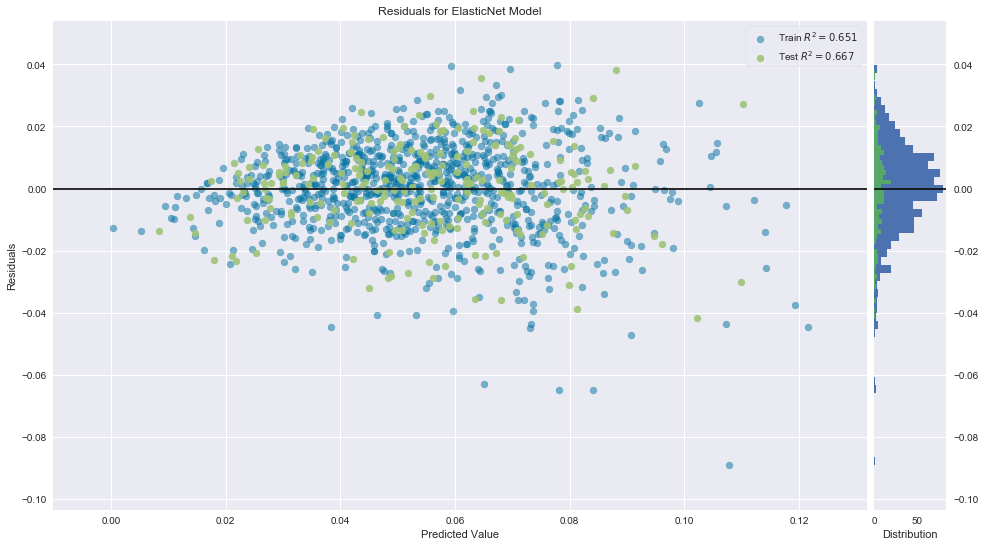

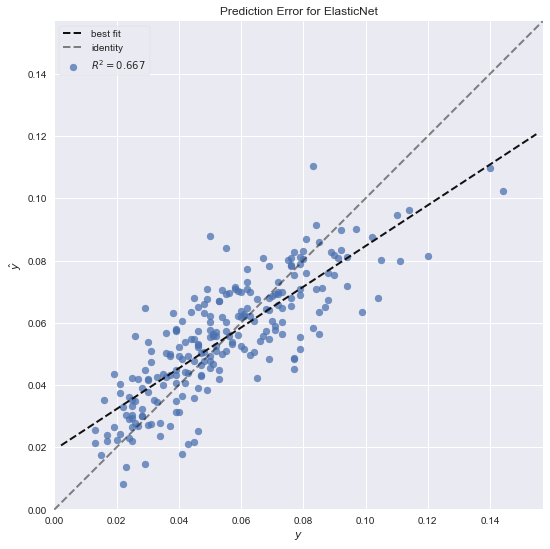

In [55]:
en_label = 'hr_rate'
en_features_3 = [
    'fly_pull_rate',
    'fly_center_rate',
    'fly_center_p95_exit_velo',
    'fly_oppo_p95_exit_velo',
    'line_center_p95_exit_velo',
    'line_oppo_p95_exit_velo'
]

en_3 = ElasticNet(alpha=0.01, l1_ratio=0.05, fit_intercept=True, copy_X=True)
en_scaler_3 = StandardScaler()

train_and_evaluate_model(df=df_threshold, label=en_label, features=en_features_3, model=en_3, scaler=en_scaler_3)

### Ada Boost Regression (all features)

MODEL FEARURE FOR AdaBoostRegressor MODEL
fly_pull_rate:                [0.2583]
fly_center_rate:              [0.0244]
fly_oppo_rate:                [0.0638]
line_pull_rate:               [0.0329]
line_center_rate:             [0.0524]
line_oppo_rate:               [0.0143]
ground_rate:                  [0.0856]
pop_rate:                     [0.0210]
fly_pull_max_exit_velo:       [0.0880]
fly_center_max_exit_velo:     [0.1225]
fly_oppo_max_exit_velo:       [0.0684]
line_pull_max_exit_velo:      [0.0169]
line_center_max_exit_velo:    [0.1132]
line_oppo_max_exit_velo:      [0.0324]
ground_max_exit_velo:         [0.0057]


MODEL METRICS FOR AdaBoostRegressor MODEL
Explained Variance Score: 0.5819
Mean Absolute Error: 0.0126
Mean Squared Error: 0.0003
R-Squared: 0.5621


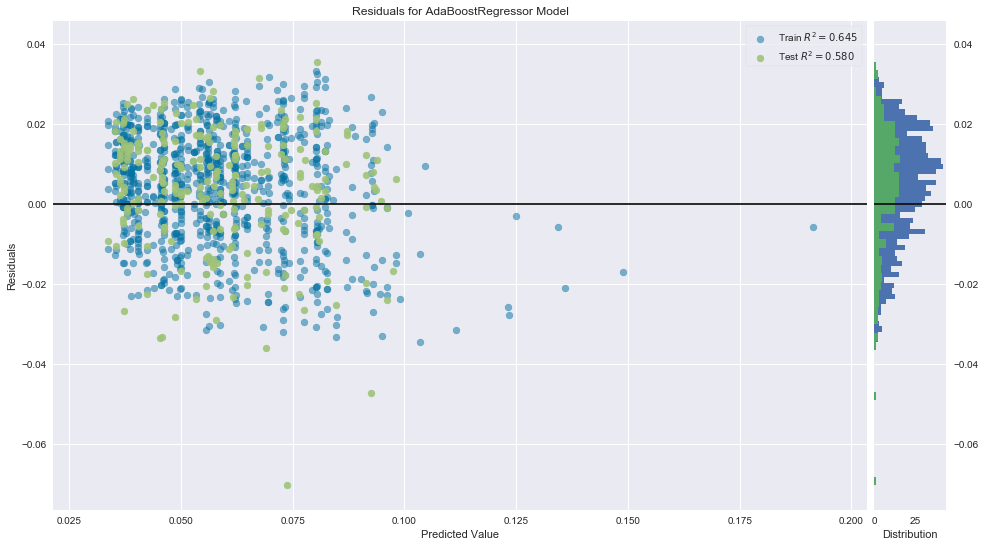

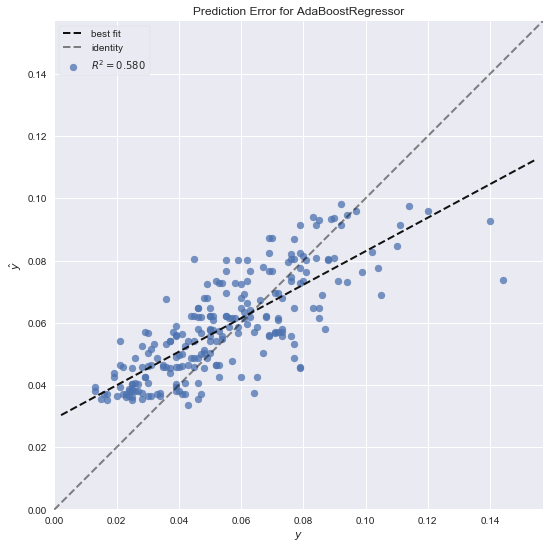

In [25]:
ab_label = 'hr_rate'
ab_features_1 = [
    'fly_pull_rate',
    'fly_center_rate',
    'fly_oppo_rate',
    'line_pull_rate',
    'line_center_rate',
    'line_oppo_rate',
    'ground_rate',
    'pop_rate',
    'fly_pull_max_exit_velo',
    'fly_center_max_exit_velo',
    'fly_oppo_max_exit_velo',
    'line_pull_max_exit_velo',
    'line_center_max_exit_velo',
    'line_oppo_max_exit_velo',
    'ground_max_exit_velo'
]

ab_1 = AdaBoostRegressor(n_estimators=50, loss='linear')
ab_scaler_1 = StandardScaler()

train_and_evaluate_model(df=df_threshold, label=ab_label, features=ab_features_1, model=ab_1, scaler=ab_scaler_1)

### Linear SVR Regression (all features)

MODEL COEFFICIENTS FOR LinearSVR MODEL
Intercept:                    [0.000]
fly_pull_rate:                [0.0598]
fly_center_rate:              [0.0028]
fly_oppo_rate:                [0.0030]
line_pull_rate:               [-0.0017]
line_center_rate:             [-0.0039]
line_oppo_rate:               [-0.0201]
ground_rate:                  [-0.0251]
pop_rate:                     [-0.0098]
fly_pull_max_exit_velo:       [0.0046]
fly_center_max_exit_velo:     [0.0355]
fly_oppo_max_exit_velo:       [0.0322]
line_pull_max_exit_velo:      [0.0150]
line_center_max_exit_velo:    [0.0287]
line_oppo_max_exit_velo:      [0.0090]
ground_max_exit_velo:         [-0.0069]


MODEL METRICS FOR LinearSVR MODEL
Explained Variance Score: 0.6253
Mean Absolute Error: 0.0117
Mean Squared Error: 0.0002
R-Squared: 0.6192


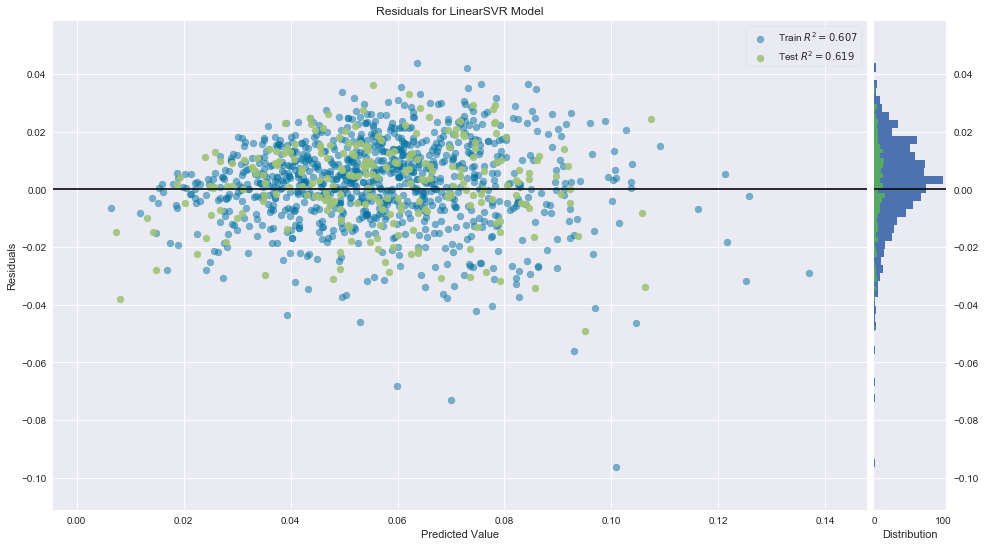

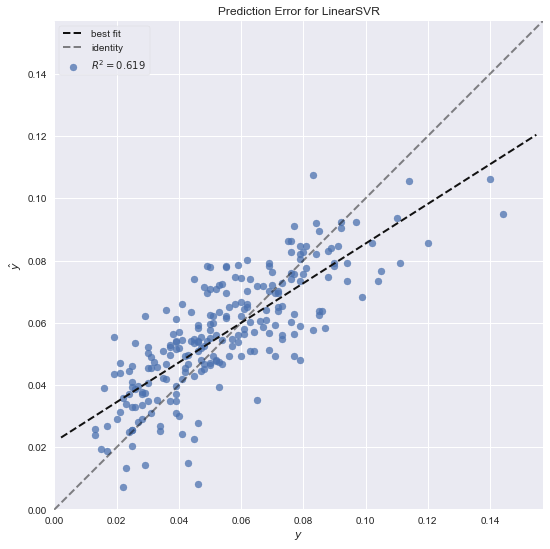

In [26]:
lsv_label = 'hr_rate'
lsv_features_1 = [
    'fly_pull_rate',
    'fly_center_rate',
    'fly_oppo_rate',
    'line_pull_rate',
    'line_center_rate',
    'line_oppo_rate',
    'ground_rate',
    'pop_rate',
    'fly_pull_max_exit_velo',
    'fly_center_max_exit_velo',
    'fly_oppo_max_exit_velo',
    'line_pull_max_exit_velo',
    'line_center_max_exit_velo',
    'line_oppo_max_exit_velo',
    'ground_max_exit_velo'
]

lsv_1 = LinearSVR(C=1.0, fit_intercept=False, random_state=42)
lsv_scaler_1 = MinMaxScaler()

train_and_evaluate_model(df=df_threshold, label=lsv_label, features=lsv_features_1, model=lsv_1, scaler=lsv_scaler_1)

### RBF SVR Regression (all features)

MODEL METRICS FOR SVR MODEL
Explained Variance Score: 0.5825
Mean Absolute Error: 0.0121
Mean Squared Error: 0.0002
R-Squared: 0.5702


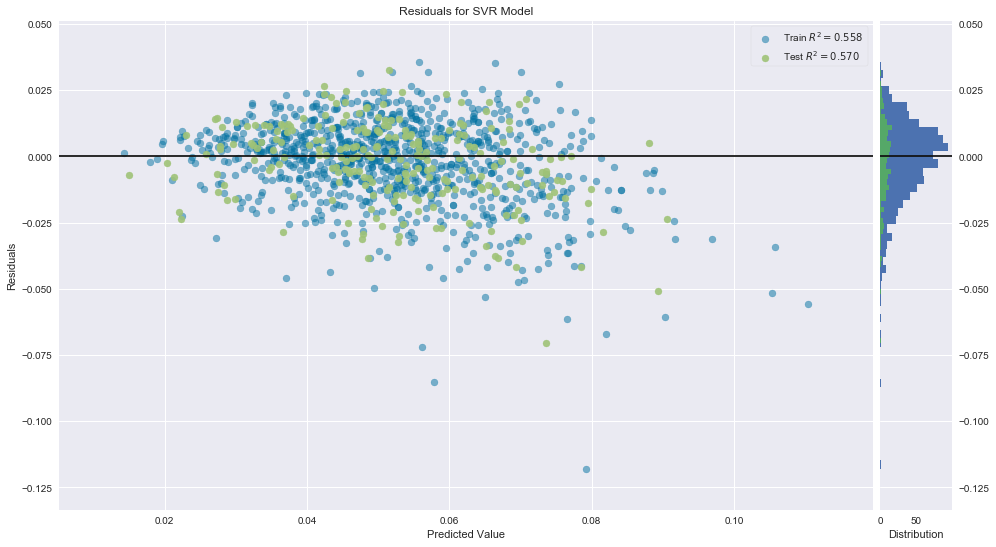

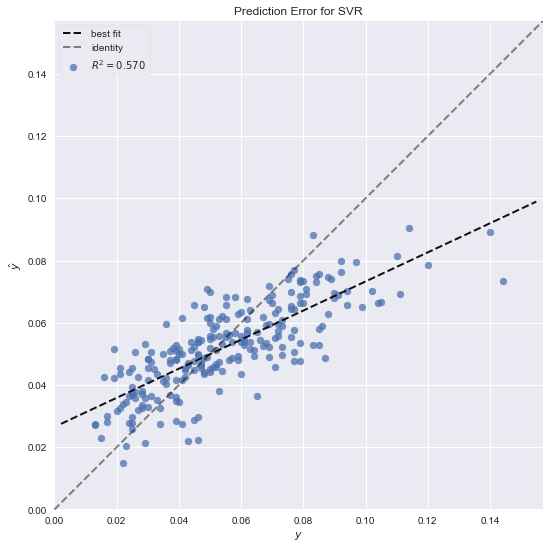

In [27]:
svr_label = 'hr_rate'
svr_features_1 = [
    'fly_pull_rate',
    'fly_center_rate',
    'fly_oppo_rate',
    'line_pull_rate',
    'line_center_rate',
    'line_oppo_rate',
    'ground_rate',
    'pop_rate',
    'fly_pull_max_exit_velo',
    'fly_center_max_exit_velo',
    'fly_oppo_max_exit_velo',
    'line_pull_max_exit_velo',
    'line_center_max_exit_velo',
    'line_oppo_max_exit_velo',
    'ground_max_exit_velo'
]

svr_1 = SVR(kernel='rbf', C=0.01, epsilon=0.005)
svr_scaler_1 = MinMaxScaler()

train_and_evaluate_model(df=df_threshold, label=svr_label, features=svr_features_1, model=svr_1, scaler=svr_scaler_1)

### RBF SVR Regression (all features using 95th percentile velocities)

MODEL METRICS FOR SVR MODEL
Explained Variance Score: 0.6209
Mean Absolute Error: 0.0114
Mean Squared Error: 0.0002
R-Squared: 0.6154


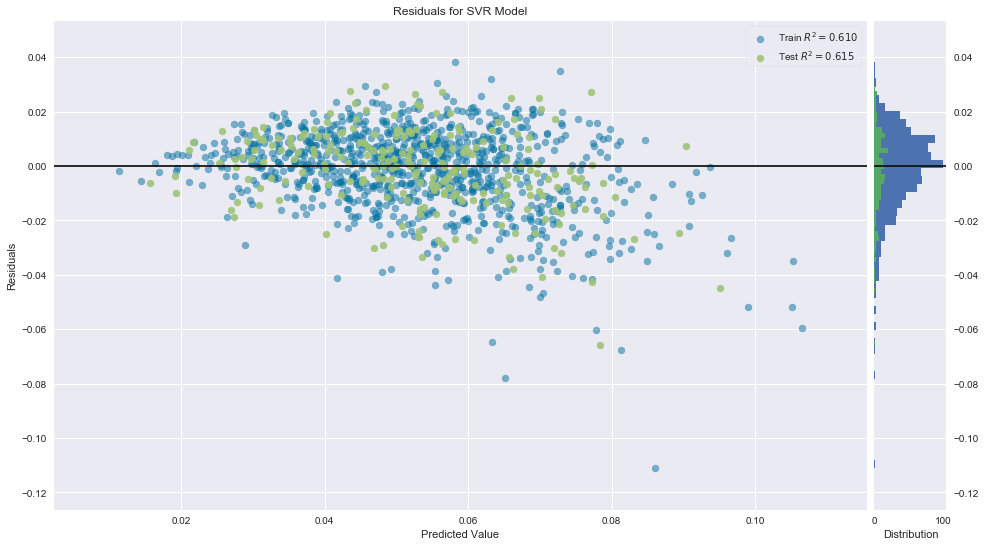

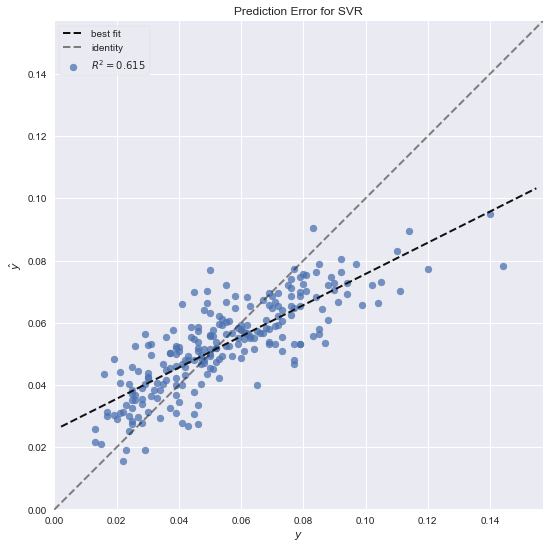

In [28]:
svr_label = 'hr_rate'
svr_features_2 = [
    'fly_pull_rate',
    'fly_center_rate',
    'fly_oppo_rate',
    'line_pull_rate',
    'line_center_rate',
    'line_oppo_rate',
    'ground_rate',
    'pop_rate',
    'fly_pull_p95_exit_velo',
    'fly_center_p95_exit_velo',
    'fly_oppo_p95_exit_velo',
    'line_pull_p95_exit_velo',
    'line_center_p95_exit_velo',
    'line_oppo_p95_exit_velo',
    'ground_p95_exit_velo'
]

svr_2 = SVR(kernel='rbf', C=0.01, epsilon=0.005)
svr_scaler_2 = MinMaxScaler()

train_and_evaluate_model(df=df_threshold, label=svr_label, features=svr_features_2, model=svr_2, scaler=svr_scaler_2)

### YOY Elastic Net Regression (all features using 95th percentile velocities)

MODEL COEFFICIENTS FOR ElasticNet MODEL
Intercept:                    [0.056]
fly_center_rate_y1:           [0.0021]
fly_oppo_rate_y1:             [0.0000]
line_pull_rate_y1:            [0.0024]
line_center_rate_y1:          [-0.0001]
line_oppo_rate_y1:            [-0.0022]
ground_rate_y1:               [-0.0043]
pop_rate_y1:                  [0.0000]
fly_pull_p95_exit_velo_y1:    [0.0000]
fly_center_p95_exit_velo_y1:  [0.0044]
fly_oppo_p95_exit_velo_y1:    [0.0019]
line_pull_p95_exit_velo_y1:   [0.0012]
line_center_p95_exit_velo_y1: [0.0040]
line_oppo_p95_exit_velo_y1:   [0.0021]
ground_p95_exit_velo_y1:      [0.0012]


MODEL METRICS FOR ElasticNet MODEL
Explained Variance Score: 0.4232
Mean Absolute Error: 0.0144
Mean Squared Error: 0.0003
R-Squared: 0.4117


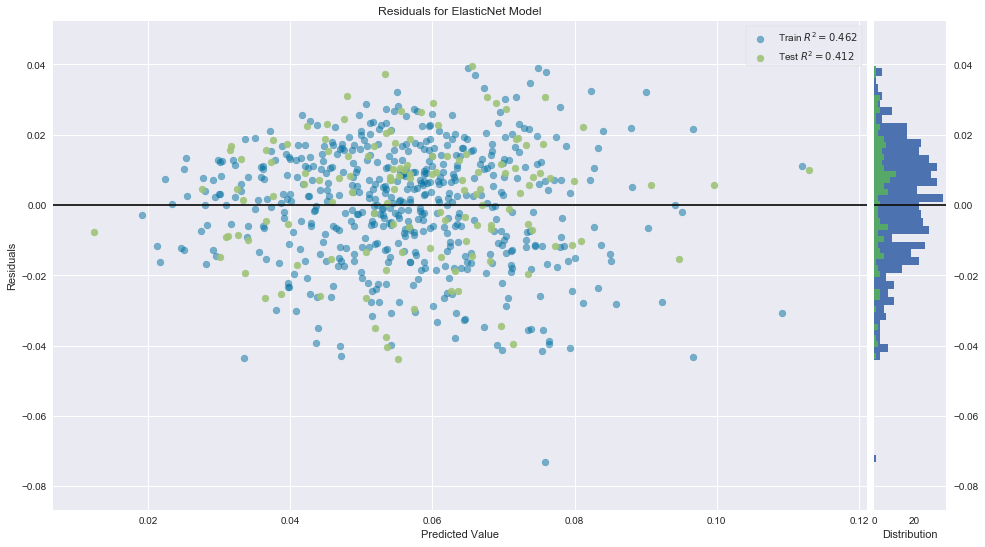

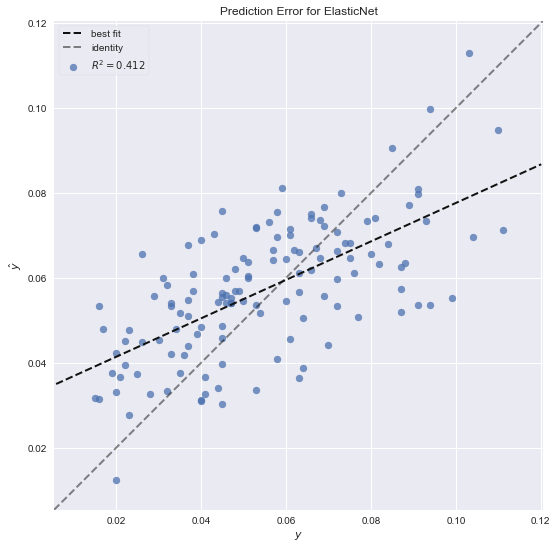

In [126]:
en_label = 'hr_rate_y2'
en_features_yoy = [
    'fly_center_rate_y1',
    'fly_oppo_rate_y1',
    'line_pull_rate_y1',
    'line_center_rate_y1',
    'line_oppo_rate_y1',
    'ground_rate_y1',
    'pop_rate_y1',
    'fly_pull_p95_exit_velo_y1',
    'fly_center_p95_exit_velo_y1',
    'fly_oppo_p95_exit_velo_y1',
    'line_pull_p95_exit_velo_y1',
    'line_center_p95_exit_velo_y1',
    'line_oppo_p95_exit_velo_y1',
    'ground_p95_exit_velo_y1'
]

en_yoy = ElasticNet(alpha=0.01, l1_ratio=0.05, fit_intercept=True, copy_X=True)
en_scaler_yoy = StandardScaler()

train_and_evaluate_model(df=df_yoy, label=en_label, features=en_features_yoy, model=en_yoy, scaler=en_scaler_yoy)

### YOY Elastic Net Regression ("important" features using 95th percentile velocities)

MODEL COEFFICIENTS FOR ElasticNet MODEL
Intercept:                    [0.056]
fly_pull_rate_y1:             [0.0028]
fly_center_rate_y1:           [0.0042]
line_pull_rate_y1:            [0.0042]
fly_center_p95_exit_velo_y1:  [0.0046]
fly_oppo_p95_exit_velo_y1:    [0.0020]
line_center_p95_exit_velo_y1: [0.0053]
line_oppo_p95_exit_velo_y1:   [0.0026]


MODEL METRICS FOR ElasticNet MODEL
Explained Variance Score: 0.4351
Mean Absolute Error: 0.0142
Mean Squared Error: 0.0003
R-Squared: 0.4219


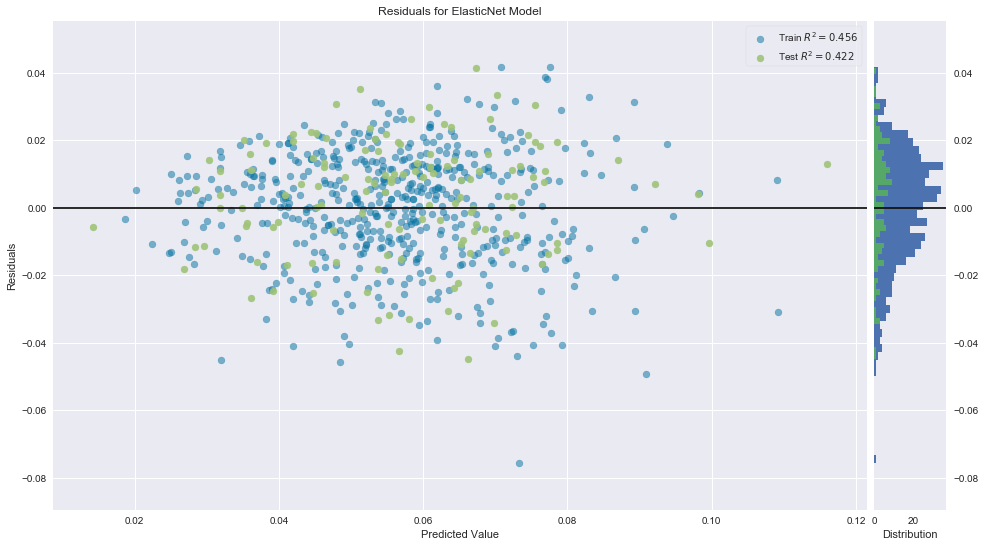

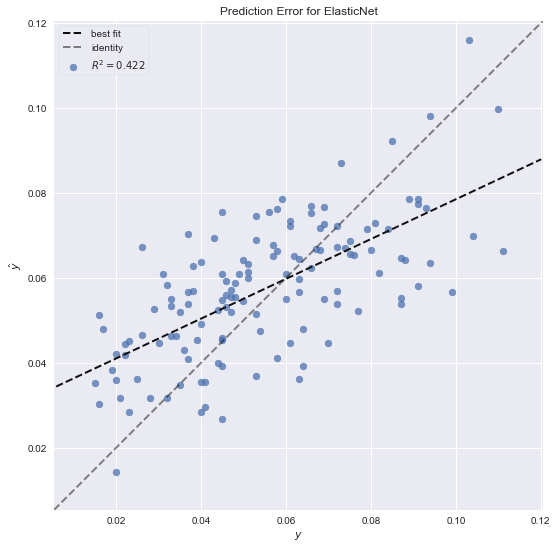

In [125]:
en_label = 'hr_rate_y2'
en_features_yoy_2 = [
    'fly_pull_rate_y1',
    'fly_center_rate_y1',
    'line_pull_rate_y1',
    'fly_center_p95_exit_velo_y1',
    'fly_oppo_p95_exit_velo_y1',
    'line_center_p95_exit_velo_y1',
    'line_oppo_p95_exit_velo_y1'
]

en_yoy_2 = ElasticNet(alpha=0.01, l1_ratio=0.05, fit_intercept=True, copy_X=True)
en_scaler_yoy_2 = StandardScaler()

train_and_evaluate_model(df=df_yoy, label=en_label, features=en_features_yoy_2, model=en_yoy_2, scaler=en_scaler_yoy_2)

## Player-specific analysis

### Player specific analysis: Joey Votto

In [30]:
df_votto = df_threshold[df_threshold['mlb_name'] == 'Joey Votto']
df_votto = df_votto.sort_values(by=['game_year'], ascending=True)
df_votto.head()

game_year  mlb_id    mlb_name fangraphs_id  bb_events  home_runs  \
3583       2015  458015  Joey Votto         4314        409         29   
3604       2016  458015  Joey Votto         4314        442         29   
3552       2017  458015  Joey Votto         4314        473         36   
3555       2018  458015  Joey Votto         4314        401         12   

      hr_rate  hr_air_rate  fly_hr_rate  line_hr_rate  fly_rate  line_rate  \
3583    0.071        0.128        0.210         0.083     0.198      0.355   
3604    0.066        0.121        0.226         0.064     0.190      0.353   
3552    0.076        0.130        0.237         0.022     0.294      0.292   
3555    0.030        0.049        0.113         0.000     0.264      0.347   

      ground_rate  pop_rate  fly_pull_rate  fly_center_rate  fly_oppo_rate  \
3583        0.435     0.012          0.027            0.108          0.064   
3604        0.443     0.014          0.018            0.090          0.081   
3552        0.402     0.013          0.038            0.116          0.133   
3555        0.382     0.007          0.027            0.142          0.095   

      line_pull_rate  line_center_rate  line_oppo_rate  ground_pull_rate  \
3583           0.090             0.176           0.088             0.267   
3604           0.111             0.147           0.095             0.247   
3552           0.097             0.129           0.066             0.237   
3555           0.077             0.142           0.127             0.234   

      ground_center_rate  ground_oppo_rate  pop_pull_rate  pop_center_rate  \
3583               0.134             0.034          0.002            0.002   
3604               0.154             0.043          0.000            0.002   
3552               0.123             0.042          0.000            0.006   
3555               0.115             0.032          0.002            0.002   

      pop_oppo_rate  fly_events  line_events  ground_events  pop_events  \
3583          0.007          81          145            178           5   
3604          0.011          84          156            196           6   
3552          0.006         139          138            190           6   
3555          0.002         106          139            153           3   

      fly_pull_events  fly_center_events  fly_oppo_events  line_pull_events  \
3583               11                 44               26                37   
3604                8                 40               36                49   
3552               18                 55               63                46   
3555               11                 57               38                31   

      line_center_events  line_oppo_events  ground_pull_events  \
3583                  72                36                 109   
3604                  65                42                 109   
3552                  61                31                 112   
3555                  57                51                  94   

      ground_center_events  ground_oppo_events  pop_pull_events  \
3583                    55                  14                1   
3604                    68                  19                0   
3552                    58                  20                0   
3555                    46                  13                1   

      pop_center_events  pop_oppo_events fly_max_exit_velo fly_p75_exit_velo  \
3583                  1                3             108.8             104.7   
3604                  1                5             107.3               103   
3552                  3                3             110.9               105   
3555                  1                1             107.5               100   

     fly_p90_exit_velo fly_p95_exit_velo fly_pull_max_exit_velo  \
3583             104.8             107.8                  107.8   
3604             104.8               105                  104.8   
3552             109.8             110.9

In [31]:
en_X_votto_2 = df_votto[en_features_2]
en_X_votto_2 = en_scaler_2.transform(en_X_votto_2)
en_2.predict(X=en_X_votto_2)

array([0.05285267, 0.04413489, 0.05388346, 0.04296205])

In [32]:
svr_X_votto_2 = df_votto[svr_features_2]
svr_X_votto_2 = svr_scaler_2.transform(svr_X_votto_2)
svr_2.predict(X=svr_X_votto_2)

array([0.05028582, 0.0432114 , 0.05105808, 0.04227019])

In [33]:
lsv_X_votto_1 = df_votto[lsv_features_1]
lsv_X_votto_1 = lsv_scaler_1.transform(lsv_X_votto_1)
lsv_1.predict(X=lsv_X_votto_1)

array([0.05582721, 0.05209372, 0.05920477, 0.04542164])

In [34]:
ab_X_votto_1 = df_votto[ab_features_1]
ab_X_votto_1 = ab_scaler_1.transform(ab_X_votto_1)
ab_1.predict(X=ab_X_votto_1)

array([0.04977994, 0.04562866, 0.07241694, 0.05659434])

In [35]:
lr_X_votto_6 = df_votto[lr_features_6]
lr_X_votto_6 = lr_scaler_6.transform(lr_X_votto_6)
lr_6.predict(X=lr_X_votto_6)

array([0.05457906, 0.04406783, 0.05537453, 0.04297758])

### Player specific analysis: Jose Ramirez

In [36]:
df_ramirez = df_threshold[df_threshold['mlb_name'] == 'Jose Ramirez']
df_ramirez = df_ramirez.sort_values(by=['game_year'], ascending=True)
df_ramirez.head()

game_year  mlb_id      mlb_name fangraphs_id  bb_events  home_runs  \
2585       2015  608070  Jose Ramirez        13510        278          6   
3615       2016  608070  Jose Ramirez        13510        490         11   
3582       2017  608070  Jose Ramirez        13510        503         29   
3397       2018  608070  Jose Ramirez        13510        474         38   

      hr_rate  hr_air_rate  fly_hr_rate  line_hr_rate  fly_rate  line_rate  \
2585    0.022        0.049        0.076         0.018     0.237      0.201   
3615    0.022        0.042        0.051         0.037     0.202      0.329   
3582    0.058        0.109        0.174         0.056     0.241      0.286   
3397    0.080        0.142        0.238         0.017     0.319      0.247   

      ground_rate  pop_rate  fly_pull_rate  fly_center_rate  fly_oppo_rate  \
2585        0.507     0.054          0.050            0.090          0.097   
3615        0.431     0.039          0.039            0.098          0.065   
3582        0.417     0.056          0.074            0.111          0.054   
3397        0.350     0.084          0.120            0.137          0.061   

      line_pull_rate  line_center_rate  line_oppo_rate  ground_pull_rate  \
2585           0.072             0.094           0.036             0.284   
3615           0.106             0.141           0.082             0.233   
3582           0.115             0.113           0.054             0.221   
3397           0.122             0.093           0.032             0.209   

      ground_center_rate  ground_oppo_rate  pop_pull_rate  pop_center_rate  \
2585               0.165             0.058          0.011            0.022   
3615               0.135             0.063          0.004            0.014   
3582               0.139             0.058          0.018            0.018   
3397               0.116             0.025          0.008            0.042   

      pop_oppo_rate  fly_events  line_events  ground_events  pop_events  \
2585          0.022          66           56            141          15   
3615          0.020          99          161            211          19   
3582          0.020         121          144            210          28   
3397          0.034         151          117            166          40   

      fly_pull_events  fly_center_events  fly_oppo_events  line_pull_events  \
2585               14                 25               27                20   
3615               19                 48               32                52   
3582               37                 56               27                58   
3397               57                 65               29                58   

      line_center_events  line_oppo_events  ground_pull_events  \
2585                  26                10                  79   
3615                  69                40                 114   
3582                  57                27                 111   
3397                  44                15                  99   

      ground_center_events  ground_oppo_events  pop_pull_events  \
2585                    46                  16                3   
3615                    66                  31                2   
3582                    70                  29                9   
3397                    55                  12                4   

      pop_center_events  pop_oppo_events fly_max_exit_velo fly_p75_exit_velo  \
2585                  6                6             106.7              96.2   
3615                  7               10             104.2              98.6   
3582                  9               10             106.3             100.4   
3397                 20               16             109.5             101.7   

     fly_p90_exit_velo fly_p95_exit_velo fly_pull_max_exit_velo  \
2585              99.5             106.7                  106.7   
3615             100.1             102.5                  101.2   
3582             103.4        

In [37]:
en_X_ramirez_2 = df_ramirez[en_features_2]
en_X_ramirez_2 = en_scaler_2.transform(en_X_ramirez_2)
en_2.predict(X=en_X_ramirez_2)

array([0.02613985, 0.03436944, 0.05432121, 0.07541481])

In [38]:
svr_X_ramirez_2 = df_ramirez[svr_features_2]
svr_X_ramirez_2 = svr_scaler_2.transform(svr_X_ramirez_2)
svr_2.predict(X=svr_X_ramirez_2)

array([0.03223474, 0.03666626, 0.05114194, 0.06599609])

In [39]:
lsv_X_ramirez_1 = df_ramirez[lsv_features_1]
lsv_X_ramirez_1 = lsv_scaler_1.transform(lsv_X_ramirez_1)
lsv_1.predict(X=lsv_X_ramirez_1)

array([0.03281699, 0.03589461, 0.06190029, 0.09032756])

In [40]:
ab_X_ramirez_1 = df_ramirez[ab_features_1]
ab_X_ramirez_1 = ab_scaler_1.transform(ab_X_ramirez_1)
ab_1.predict(X=ab_X_ramirez_1)

array([0.04048551, 0.03726102, 0.06220308, 0.08084375])

In [41]:
lr_X_ramirez_6 = df_ramirez[lr_features_6]
lr_X_ramirez_6 = lr_scaler_6.transform(lr_X_ramirez_6)
lr_6.predict(X=lr_X_ramirez_6)

array([0.02566087, 0.03402128, 0.05521244, 0.07654658])

### Player specific analysis: Giancarlo Stanton

In [42]:
df_stanton = df_threshold[df_threshold['mlb_name'] == 'Giancarlo Stanton']
df_stanton = df_stanton.sort_values(by=['game_year'], ascending=True)
df_stanton.head()

game_year  mlb_id           mlb_name fangraphs_id  bb_events  home_runs  \
2586       2015  519317  Giancarlo Stanton         4949        179         27   
2745       2016  519317  Giancarlo Stanton         4949        267         27   
3160       2017  519317  Giancarlo Stanton         4949        422         59   
3063       2018  519317  Giancarlo Stanton         4949        404         38   

      hr_rate  hr_air_rate  fly_hr_rate  line_hr_rate  fly_rate  line_rate  \
2586    0.151        0.270        0.250         0.286     0.246      0.313   
2745    0.101        0.201        0.209         0.194     0.251      0.251   
3160    0.140        0.304        0.495         0.113     0.230      0.230   
3063    0.094        0.205        0.281         0.124     0.238      0.220   

      ground_rate  pop_rate  fly_pull_rate  fly_center_rate  fly_oppo_rate  \
2586        0.374     0.067          0.050            0.145          0.050   
2745        0.431     0.067          0.052            0.116          0.082   
3160        0.460     0.081          0.066            0.102          0.059   
3063        0.465     0.077          0.050            0.126          0.062   

      line_pull_rate  line_center_rate  line_oppo_rate  ground_pull_rate  \
2586           0.106             0.156           0.050             0.212   
2745           0.056             0.150           0.045             0.213   
3160           0.081             0.104           0.040             0.218   
3063           0.077             0.084           0.059             0.196   

      ground_center_rate  ground_oppo_rate  pop_pull_rate  pop_center_rate  \
2586               0.106             0.056          0.017            0.017   
2745               0.157             0.060          0.015            0.015   
3160               0.187             0.055          0.017            0.033   
3063               0.198             0.072          0.005            0.037   

      pop_oppo_rate  fly_events  line_events  ground_events  pop_events  \
2586          0.034          44           56             67          12   
2745          0.037          67           67            115          18   
3160          0.031          97           97            194          34   
3063          0.035          96           89            188          31   

      fly_pull_events  fly_center_events  fly_oppo_events  line_pull_events  \
2586                9                 26                9                19   
2745               14                 31               22                15   
3160               28                 43               25                34   
3063               20                 51               25                31   

      line_center_events  line_oppo_events  ground_pull_events  \
2586                  28                 9                  38   
2745                  40                12                  57   
3160                  44                17                  92   
3063                  34                24                  79   

      ground_center_events  ground_oppo_events  pop_pull_events  \
2586                    19                  10                3   
2745                    42                  16                4   
3160                    79                  23                7   
3063                    80                  29                2   

      pop_center_events  pop_oppo_events fly_max_exit_velo fly_p75_exit_velo  \
2586                  3                6             114.3             108.2   
2745                  4               10             116.8             107.8   
3160                 14               13             118.7             111.9   
3063                 15               14             117.9             106.9   

     fly_p90_exit_velo fly_p95_exit_velo fly_pull_max_exit_velo  \
2586             111.4             112.8                  111.4   
2745             114.7             115.8                  115.8   
3160 

In [43]:
en_X_stanton_2 = df_stanton[en_features_2]    
en_X_stanton_2 = en_scaler_2.transform(en_X_stanton_2)
en_2.predict(X=en_X_stanton_2)

array([0.109121  , 0.09929147, 0.10891397, 0.10179274])

In [44]:
svr_X_stanton_2 = df_stanton[svr_features_2]
svr_X_stanton_2 = svr_scaler_2.transform(svr_X_stanton_2)
svr_2.predict(X=svr_X_stanton_2)

array([0.09901693, 0.09080495, 0.09505401, 0.09369921])

In [45]:
lsv_X_stanton_1 = df_stanton[lsv_features_1]
lsv_X_stanton_1 = lsv_scaler_1.transform(lsv_X_stanton_1)
lsv_1.predict(X=lsv_X_stanton_1)

array([0.10451008, 0.10368448, 0.10621533, 0.10068939])

In [46]:
ab_X_stanton_1 = df_stanton[ab_features_1]
ab_X_stanton_1 = ab_scaler_1.transform(ab_X_stanton_1)
ab_1.predict(X=ab_X_stanton_1)

array([0.1233352, 0.0869661, 0.09264  , 0.0869661])

In [47]:
lr_X_stanton_6 = df_stanton[lr_features_6]
lr_X_stanton_6 = lr_scaler_6.transform(lr_X_stanton_6)
lr_6.predict(X=lr_X_stanton_6)

array([0.11172409, 0.10216177, 0.11070341, 0.10242065])

### Player-specific analysis: Franmil Reyes

In [48]:
df_franmil = df_threshold[df_threshold['mlb_name'] == 'Franmil Reyes']
df_franmil = df_franmil.sort_values(by=['game_year'], ascending=True)
df_franmil.head()

game_year  mlb_id       mlb_name fangraphs_id  bb_events  home_runs  \
2356       2018  614177  Franmil Reyes        14566        176         16   

      hr_rate  hr_air_rate  fly_hr_rate  line_hr_rate  fly_rate  line_rate  \
2356    0.091        0.203         0.35         0.051     0.227      0.222   

      ground_rate  pop_rate  fly_pull_rate  fly_center_rate  fly_oppo_rate  \
2356        0.523     0.028          0.034            0.114          0.074   

      line_pull_rate  line_center_rate  line_oppo_rate  ground_pull_rate  \
2356           0.045             0.097           0.074             0.165   

      ground_center_rate  ground_oppo_rate  pop_pull_rate  pop_center_rate  \
2356               0.284             0.074            0.0            0.017   

      pop_oppo_rate  fly_events  line_events  ground_events  pop_events  \
2356          0.011          40           39             92           5   

      fly_pull_events  fly_center_events  fly_oppo_events  line_pull_events  \
2356                6                 20               13                 8   

      line_center_events  line_oppo_events  ground_pull_events  \
2356                  17                13                  29   

      ground_center_events  ground_oppo_events  pop_pull_events  \
2356                    50                  13                0   

      pop_center_events  pop_oppo_events fly_max_exit_velo fly_p75_exit_velo  \
2356                  3                2             114.1             111.2   

     fly_p90_exit_velo fly_p95_exit_velo fly_pull_max_exit_velo  \
2356             111.2             111.2                  109.7   

     fly_pull_p75_exit_velo fly_pull_p90_exit_velo fly_pull_p95_exit_velo  \
2356                  109.7                  109.7                  109.7   

     fly_center_max_exit_velo fly_center_p75_exit_velo  \
2356                    114.1                    105.8   

     fly_center_p90_exit_velo fly_center_p95_exit_velo fly_oppo_max_exit_velo  \
2356                    109.5                    109.8                  108.1   

     fly_oppo_p75_exit_velo fly_oppo_p90_exit_velo fly_oppo_p95_exit_velo  \
2356                     97                  104.8                  108.1   

     line_max_exit_velo line_p75_exit_velo line_p90_exit_velo  \
2356              115.4              114.6              115.4   

     line_p95_exit_velo line_pull_max_exit_velo line_pull_p75_exit_velo  \
2356              115.4                   115.4                   112.3   

     line_pull_p90_exit_velo line_pull_p95_exit_velo  \
2356                   115.4                   115.4   

     line_center_max_exit_velo line_center_p75_exit_velo  \
2356                       113                     106.9   

     line_center_p90_exit_velo line_center_p95_exit_velo  \
2356                       111                       113   

     line_oppo_max_exit_velo line_oppo_p75_exit_velo line_oppo_p90_exit_velo  \
2356                   108.4                   106.9                   108.2   

     line_oppo_p95_exit_velo ground_max_exit_velo ground_p75_exit_velo  \
2356                   108.4                114.9                103.6   

     ground_p90_exit_velo ground_p95_exit_velo ground_pull_max_exit_velo  \
2356                107.7                113.3                     112.3   

     ground_pull_p75_exit_velo ground_pull_p90_exit_velo  \
2356                      97.3                     101.1   

     ground_pull_p95_exit_velo ground_center_max_exit_velo  \
2356                     105.9                       114.9   

     ground_center_p75_exit_velo ground_center_p90_exit_velo  \
2356                       103.6                       107.7   

     ground_center_p95_exit_velo ground_oppo_max_exit_velo  \
2356                       113.3                     106.5   

     ground_oppo_p75_exit_velo ground_oppo_p90_exit_velo  \
2356                      94.6                     102.9   

     ground_oppo_p95_exit_velo  
2356     

In [49]:
en_X_franmil_2 = df_franmil[en_features_2]    
en_X_franmil_2 = en_scaler_2.transform(en_X_franmil_2)
en_2.predict(X=en_X_franmil_2)

array([0.0771257])

In [50]:
svr_X_franmil_2 = df_franmil[svr_features_2]
svr_X_franmil_2 = svr_scaler_2.transform(svr_X_franmil_2)
svr_2.predict(X=svr_X_franmil_2)

array([0.07171537])

In [51]:
lsv_X_franmil_1 = df_franmil[lsv_features_1]
lsv_X_franmil_1 = lsv_scaler_1.transform(lsv_X_franmil_1)
lsv_1.predict(X=lsv_X_franmil_1)

array([0.07872435])

In [52]:
ab_X_franmil_1 = df_franmil[ab_features_1]
ab_X_franmil_1 = ab_scaler_1.transform(ab_X_franmil_1)
ab_1.predict(X=ab_X_franmil_1)

array([0.07284729])

In [53]:
lr_X_franmil_6 = df_franmil[lr_features_6]
lr_X_franmil_6 = lr_scaler_6.transform(lr_X_franmil_6)
lr_6.predict(X=lr_X_franmil_6)

array([0.07872416])

## Leaguewide Predictions

In [115]:
df_2018 = df_threshold[df_threshold['game_year'] == 2018].copy()
df_2017 = df_threshold[df_threshold['game_year'] == 2017].copy()

In [117]:
features_y1 = [
    'hr_rate',
    'fly_pull_rate',
    'fly_center_rate',
    'line_pull_rate',
    'fly_center_p95_exit_velo',
    'fly_oppo_p95_exit_velo',
    'line_center_p95_exit_velo',
    'line_oppo_p95_exit_velo'
]

df_X_2017 = df_2017[features_y1]
df_X_2017 = en_scaler_yoy_2.transform(df_X_2017)

df_2017['predicted_hr_rate'] = en_yoy_2.predict(X=df_X_2017)
df_2017['predicted_hr_rate_delta'] = df_2017['predicted_hr_rate'] - df_2017['hr_rate']

df_X_2018 = df_2018[features_y1]
df_X_2018 = en_scaler_yoy_2.transform(df_X_2018)

df_2018['predicted_hr_rate'] = en_yoy_2.predict(X=df_X_2018)
df_2018['predicted_hr_rate_delta'] = df_2018['predicted_hr_rate'] - df_2018['hr_rate']

In [118]:
show_cols = [
    'mlb_name',
    'bb_events',
    'home_runs',
    'hr_rate',
    'fly_pull_rate',
    'fly_center_rate',
    'fly_center_p95_exit_velo',
    'fly_oppo_p95_exit_velo',
    'line_center_p95_exit_velo',
    'line_oppo_p95_exit_velo',
    'predicted_hr_rate',
    'predicted_hr_rate_delta'
]

In [119]:
df_2017[show_cols].sort_values(by=['predicted_hr_rate'], ascending=False).head(10)

mlb_name  bb_events  home_runs  hr_rate  fly_pull_rate  \
3059        Aaron Judge        332         52    0.157          0.063   
2595         Joey Gallo        247         41    0.166          0.105   
2093         Matt Olson        122         24    0.197          0.123   
3160  Giancarlo Stanton        422         59    0.140          0.066   
2867      J.D. Martinez        303         45    0.149          0.040   
2613        Mike Zunino        222         25    0.113          0.104   
2767        Miguel Sano        248         27    0.109          0.060   
3275        Nelson Cruz        410         39    0.095          0.049   
2869         Mike Trout        304         33    0.109          0.053   
3166        Khris Davis        367         43    0.117          0.030   

      fly_center_rate fly_center_p95_exit_velo fly_oppo_p95_exit_velo  \
3059            0.175                    112.5                  110.5   
2595            0.194                      113                  103.2   
2093            0.123                      111                   99.9   
3160            0.102                    115.3                  107.2   
2867            0.129                    109.9                  107.4   
2613            0.153                    108.4                  101.8   
2767            0.145                    111.1                  107.6   
3275            0.154                    111.3                  106.1   
2869            0.161                    108.4                   97.4   
3166            0.169                    109.4                  104.4   

     line_center_p95_exit_velo line_oppo_p95_exit_velo  predicted_hr_rate  \
3059                       119                   112.8           0.122515   
2595                     111.9                   110.2           0.117558   
2093                     109.7                   101.2           0.110339   
3160                     115.6                   113.2           0.105080   
2867                     112.5                   110.9           0.097529   
2613                     114.1                   106.5           0.097087   
2767                     110.5                   111.3           0.093047   
3275                     113.6                   113.6           0.092016   
2869                     110.5                   113.6           0.089660   
3166                     108.8                   109.7           0.088752   

      predicted_hr_rate_delta  
3059                -0.034485  
2595                -0.048442  
2093                -0.086661  
3160                -0.034920  
2867                -0.051471  
2613                -0.015913  
2767                -0.015953  
3275                -0.002984  
2869                -0.019340  
3166                -0.028248

In [120]:
df_2017[show_cols].sort_values(by=['predicted_hr_rate_delta'], ascending=False).head(10)

mlb_name  bb_events  home_runs  hr_rate  fly_pull_rate  \
3129      Alex Gordon        340          9    0.026          0.041   
3365  Xander Bogaerts        437         10    0.023          0.027   
3256   Dansby Swanson        360          6    0.017          0.031   
3374     Buster Posey        428         12    0.028          0.044   
2476      Brad Miller        228          9    0.039          0.035   
2695      Evan Gattis        235         12    0.051          0.047   
3148   Avisail Garcia        402         18    0.045          0.015   
2817       Manny Pina        249          9    0.036          0.056   
2488   Bradley Zimmer        197          8    0.041          0.025   
3614       Jed Lowrie        450         14    0.031          0.067   

      fly_center_rate fly_center_p95_exit_velo fly_oppo_p95_exit_velo  \
3129            0.124                    106.4                   99.3   
3365            0.073                    106.6                   95.9   
3256            0.083                    101.2                   97.8   
3374            0.121                    104.7                   97.6   
2476            0.118                    106.6                   98.9   
2695            0.128                    105.7                   98.2   
3148            0.107                    109.6                  105.5   
2817            0.137                    103.4                  100.6   
2488            0.086                    112.2                  102.9   
3614            0.122                    101.9                   98.8   

     line_center_p95_exit_velo line_oppo_p95_exit_velo  predicted_hr_rate  \
3129                     107.1                   100.3           0.052951   
3365                     108.2                   101.1           0.044891   
3256                     104.3                   104.5           0.038671   
3374                     105.3                     100           0.047634   
2476                     110.4                   108.2           0.058327   
2695                     109.6                   105.4           0.069288   
3148                     110.2                   107.6           0.062899   
2817                     106.2                      98           0.053779   
2488                     109.2                   106.4           0.057418   
3614                     104.2                   101.6           0.047331   

      predicted_hr_rate_delta  
3129                 0.026951  
3365                 0.021891  
3256                 0.021671  
3374                 0.019634  
2476                 0.019327  
2695                 0.018288  
3148                 0.017899  
2817                 0.017779  
2488                 0.016418  
3614                 0.016331

In [121]:
df_2017[show_cols].sort_values(by=['predicted_hr_rate_delta'], ascending=True).head(15)

mlb_name  bb_events  home_runs  hr_rate  fly_pull_rate  \
2093         Matt Olson        122         24    0.197          0.123   
2232       Rhys Hoskins        125         18    0.144          0.144   
2867      J.D. Martinez        303         45    0.149          0.040   
2595         Joey Gallo        247         41    0.166          0.105   
2018     Jake Marisnick        137         16    0.117          0.124   
2206        Pat Valaika        131         13    0.099          0.092   
2477        Mike Napoli        251         29    0.116          0.147   
2910     Cody Bellinger        328         39    0.119          0.101   
3160  Giancarlo Stanton        422         59    0.140          0.066   
3059        Aaron Judge        332         52    0.157          0.063   
2492     Kyle Schwarber        266         30    0.113          0.075   
2747     Josh Donaldson        297         33    0.111          0.074   
2697           Ian Happ        237         24    0.101          0.076   
2861   Michael Conforto        250         26    0.104          0.056   
2161    Nicky Delmonico        108          9    0.083          0.074   

      fly_center_rate fly_center_p95_exit_velo fly_oppo_p95_exit_velo  \
2093            0.123                      111                   99.9   
2232            0.160                    103.4                  101.1   
2867            0.129                    109.9                  107.4   
2595            0.194                      113                  103.2   
2018            0.139                      109                   97.2   
2206            0.145                    101.5                   98.3   
2477            0.163                      108                  102.2   
2910            0.140                    105.4                  101.9   
3160            0.102                    115.3                  107.2   
3059            0.175                    112.5                  110.5   
2492            0.120                    110.9                  102.2   
2747            0.145                    106.5                   99.6   
2697            0.105                    105.5                  107.8   
2861            0.108                    108.1                  100.6   
2161            0.074                     98.5                   89.8   

     line_center_p95_exit_velo line_oppo_p95_exit_velo  predicted_hr_rate  \
2093                     109.7                   101.2           0.110339   
2232                     106.5                   104.8           0.085860   
2867                     112.5                   110.9           0.097529   
2595                     111.9                   110.2           0.117558   
2018                     107.2                    98.7           0.073097   
2206                     104.3                    97.6           0.060717   
2477                     104.6                   104.9           0.077758   
2910                       110                   109.8           0.082609   
3160                     115.6                   113.2           0.105080   
3059                       119                   112.8           0.122515   
2492                     110.5                     105           0.084141   
2747                       110                     107           0.082285   
2697                     108.9                   100.6           0.072293   
2861                     108.9                   107.2           0.075680   
2161                     108.4                    97.2           0.054689   

      predicted_hr_rate_delta  
2093                -0.086661  
2232                -0.058140  
2867                -0.051471  
2595                -0.048442  
2018                -0.043903  
2206                -0.038283  
2477                -0.038242  
2910                -0.036391  
3160                -0.034920  
3059                -0.034485  
2492                -0.028859  
2747                -0.028715  
2697                -0.02870

In [122]:
df_2018[show_cols].sort_values(by=['predicted_hr_rate'], ascending=False).head(10)

mlb_name  bb_events  home_runs  hr_rate  fly_pull_rate  \
2790         Joey Gallo        285         40    0.140          0.063   
2820        Aaron Judge        263         27    0.103          0.034   
3180         Mike Trout        341         39    0.114          0.076   
3063  Giancarlo Stanton        404         38    0.094          0.050   
2518       Daniel Palka        259         27    0.104          0.069   
3139        Khris Davis        399         48    0.120          0.043   
2363       Tyler Austin        149         17    0.114          0.047   
2382       Gary Sanchez        216         18    0.083          0.093   
2954        Nelson Cruz        382         37    0.097          0.058   
2446        Mike Zunino        213         20    0.094          0.099   

      fly_center_rate fly_center_p95_exit_velo fly_oppo_p95_exit_velo  \
2790            0.218                    111.5                  108.9   
2820            0.125                    113.9                  109.2   
3180            0.176                    109.3                  102.6   
3063            0.126                      112                    110   
2518            0.127                    111.4                  107.7   
3139            0.185                    108.3                  106.8   
2363            0.121                    111.7                  105.8   
2382            0.144                    111.5                  103.3   
2954            0.162                    109.8                  101.8   
2446            0.122                    110.8                  106.1   

     line_center_p95_exit_velo line_oppo_p95_exit_velo  predicted_hr_rate  \
2790                     115.7                   110.6           0.119009   
2820                       117                   112.1           0.100436   
3180                       112                   104.6           0.094654   
3063                     117.9                   112.6           0.094329   
2518                     115.5                   108.5           0.090431   
3139                     109.3                   107.3           0.087609   
2363                     110.1                   102.3           0.086801   
2382                     114.2                   107.6           0.086741   
2954                     113.1                   110.2           0.085132   
2446                     111.1                   101.4           0.084798   

      predicted_hr_rate_delta  
2790                -0.020991  
2820                -0.002564  
3180                -0.019346  
3063                 0.000329  
2518                -0.013569  
3139                -0.032391  
2363                -0.027199  
2382                 0.003741  
2954                -0.011868  
2446                -0.009202

In [123]:
df_2018[show_cols].sort_values(by=['predicted_hr_rate_delta'], ascending=False).head(10)

mlb_name  bb_events  home_runs  hr_rate  fly_pull_rate  \
2644       Jay Bruce        237          9    0.038          0.055   
3027       Josh Bell        390         12    0.031          0.033   
3207    Jordy Mercer        301          6    0.020          0.023   
2827      Adam Engel        293          6    0.020          0.068   
3300  Brian Anderson        446         11    0.025          0.018   
2672    Jesse Winker        229          7    0.031          0.017   
2525    Jorge Alfaro        202         10    0.050          0.020   
2778       Wil Myers        219         11    0.050          0.046   
3044   Scott Kingery        321          8    0.025          0.050   
2669  Chris Iannetta        209         11    0.053          0.048   

      fly_center_rate fly_center_p95_exit_velo fly_oppo_p95_exit_velo  \
2644            0.228                    106.5                  102.1   
3027            0.128                    107.4                  103.1   
3207            0.116                    104.9                  100.3   
2827            0.082                    103.4                   97.9   
3300            0.094                    107.6                  101.9   
2672            0.140                    104.8                    101   
2525            0.119                    114.1                  109.6   
2778            0.110                    109.6                  101.2   
3044            0.150                    103.2                   97.3   
2669            0.144                    111.2                   99.9   

     line_center_p95_exit_velo line_oppo_p95_exit_velo  predicted_hr_rate  \
2644                     108.7                    94.9           0.068787   
3027                       112                   110.6           0.060730   
3207                     103.5                      96           0.048748   
2827                     108.5                   107.4           0.047477   
3300                     108.3                     106           0.049973   
2672                     107.7                   105.8           0.055429   
2525                     114.9                   106.7           0.074178   
2778                     110.7                   107.5           0.073622   
3044                     106.2                   105.5           0.048403   
2669                     111.6                   108.4           0.076298   

      predicted_hr_rate_delta  
2644                 0.030787  
3027                 0.029730  
3207                 0.028748  
2827                 0.027477  
3300                 0.024973  
2672                 0.024429  
2525                 0.024178  
2778                 0.023622  
3044                 0.023403  
2669                 0.023298

In [124]:
df_2018[show_cols].sort_values(by=['predicted_hr_rate_delta'], ascending=True).head(10)

mlb_name  bb_events  home_runs  hr_rate  fly_pull_rate  \
2741          Max Muncy        254         35    0.138          0.106   
2073       Ryan O'Hearn        102         12    0.118          0.078   
3139        Khris Davis        399         48    0.120          0.043   
2363       Tyler Austin        149         17    0.114          0.047   
2317        Eric Thames        147         16    0.109          0.095   
2593         Matt Adams        225         21    0.093          0.124   
2472         David Dahl        179         16    0.089          0.067   
2500  Charlie Culberson        208         12    0.058          0.058   
2790         Joey Gallo        285         40    0.140          0.063   
2194      Mark Reynolds        139         13    0.094          0.094   

      fly_center_rate fly_center_p95_exit_velo fly_oppo_p95_exit_velo  \
2741            0.118                    108.8                  103.1   
2073            0.108                    105.8                  104.2   
3139            0.185                    108.3                  106.8   
2363            0.121                    111.7                  105.8   
2317            0.143                    105.1                   98.6   
2593            0.111                    105.5                   99.9   
2472            0.117                    103.6                   99.1   
2500            0.067                    100.8                   95.3   
2790            0.218                    111.5                  108.9   
2194            0.122                    105.9                     98   

     line_center_p95_exit_velo line_oppo_p95_exit_velo  predicted_hr_rate  \
2741                     104.7                   101.7           0.080431   
2073                     105.7                   101.5           0.073139   
3139                     109.3                   107.3           0.087609   
2363                     110.1                   102.3           0.086801   
2317                     110.8                   101.3           0.082629   
2593                     106.3                   104.8           0.066844   
2472                     106.5                   103.3           0.066232   
2500                     101.9                    99.7           0.036490   
2790                     115.7                   110.6           0.119009   
2194                     108.9                   108.6           0.073246   

      predicted_hr_rate_delta  
2741                -0.057569  
2073                -0.044861  
3139                -0.032391  
2363                -0.027199  
2317                -0.026371  
2593                -0.026156  
2472                -0.022768  
2500                -0.021510  
2790                -0.020991  
2194                -0.020754